# LiveKit Voice Agents LLM Benchmarking

In the cascade Voice Agents pipeline (ASR → LLM → TTS), the LLM stage is one of the main contributors to overall latency.  
This notebook analyzes and compares the performance of LLM models available for free or on a trial basis in the LiveKit Voice Agents SDK.

---

### Important Note

Most models were accessed via the LiveKit Inference Gateway:  
`inference.LLM(model=model_name)`

Cerebras models were accessed via the dedicated Cerebras plugin:  
`openai.LLM.with_cerebras(model=model_name)` using a trial quota.

The reported measurements may reflect not only model-level characteristics, but also differences in serving infrastructure (e.g., routing, resource allocation, batching strategy), which can influence both latency (TTFT) and throughput.

### Load the gathered data

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import seaborn as sns

In [2]:
notebook_dir = Path.cwd()
logs_path = notebook_dir / "logs/llm"

In [11]:
metrics_rows = []
ttf_stats_rows = []

for provider_dir in logs_path.iterdir():
    if provider_dir.is_dir():
        provider = provider_dir.name
        
        desc_file = provider_dir / "descriptions.txt"
        if desc_file.exists():
            with open(desc_file, 'r') as f:
                model_descriptions = {
                    line.split(':', 1)[0].strip(): line.split(':', 1)[1].strip()
                    for line in f if ':' in line
                }

        for model_file in provider_dir.iterdir():
            if model_file.is_file() and model_file.suffix == ".csv":
                df = pd.read_csv(model_file)
                model = model_file.stem
                
                for _, row in df.iterrows():
                    metrics_rows.append({
                        "provider": provider,
                        "model": model,
                        "ttft": row["ttft"],
                        "tokens_per_second": row["tokens_per_second"]
                    })

                ttft_mean = df["ttft"].mean()
                ttft_std  = df["ttft"].std()
                ttft_min  = df["ttft"].min()
                ttft_max  = df["ttft"].max()

                ttf_stats_rows.append({
                    "provider": provider,
                    "model": model,
                    "ttft_mean": ttft_mean,
                    "ttft_std": ttft_std,
                    "ttft_min": ttft_min,
                    "ttft_max": ttft_max,
                    "description": model_descriptions.get(model, "")
                })

metrics_df = pd.DataFrame(metrics_rows, columns=["provider", "model", "ttft", "tokens_per_second"])
ttft_stats_df = pd.DataFrame(
    ttf_stats_rows,
    columns=["provider", "model", "ttft_mean", "ttft_std", "ttft_min", "ttft_max", "description"]
)

### Time To First Token (TTFT) metric

Time To First Token (TTFT) — the elapsed time between sending a request to a language model (LLM) and receiving the first token of the generated response. TTFT measures the model’s initial response latency, reflecting how quickly the LLM starts producing output after receiving input.

This metric is especially important for interactive applications, such as voice agents or real-time chat, because a lower TTFT directly impacts the perceived responsiveness and user experience. Even if the total generation time is acceptable, a high TTFT can make the system feel sluggish.

### Models ordered by average TTFT within each provider

In [12]:
group_sizes = ttft_stats_df.groupby("provider").size()

# Map each provider to its group size
ttft_stats_df["group_size"] = ttft_stats_df["provider"].map(group_sizes)

# Sort by group size descending, then by ttft_mean ascending
ttft_stats_df_sorted = ttft_stats_df.sort_values(
    by=["group_size", "provider", "ttft_mean"],
    ascending=[False, True, True]
).drop(columns="group_size").reset_index(drop=True)

ttft_stats_df = ttft_stats_df.drop(columns="group_size")

In [13]:
pd.set_option('display.max_colwidth', None)
ttft_stats_df_sorted

,provider,model,ttft_mean,ttft_std,ttft_min,ttft_max,description
0,openai,gpt-4.1-nano,0.931200,0.166418,0.7199,1.3116,"Smallest model in the GPT-4.1 family, positioned for cost-efficient and lightweight deployments."
1,openai,gpt-4o,0.935069,0.106027,0.8309,1.1486,Multimodal model from the GPT-4o series supporting text and audio inputs.
2,openai,gpt-4.1-mini,0.975650,0.111029,0.7867,1.1692,Compact variant of GPT-4.1 balancing general capability and resource usage.
3,openai,gpt_4o_mini,0.981700,0.110266,0.7930,1.1793,Reduced-size version of GPT-4o optimized for lower compute usage.
4,openai,gpt-4.1,1.005069,0.177367,0.7672,1.3394,Full-scale GPT-4.1 model intended for general-purpose reasoning and instruction following.
5,openai,gpt-oss-120b,1.041856,0.270428,0.6666,1.7661,Open-weight 120B Mixture-of-Experts model available via hosted inference.
6,openai,gpt-5-mini,5.014762,2.370728,2.0132,10.2962,Mid-tier model in the GPT-5 family targeting balanced reasoning workloads.
7,openai,gpt-5-nano,14.332187,28.706053,2.9065,120.8473,Compact reasoning-capable model in the GPT-5 family.
8,openai,gpt-5,19.967556,30.490490,3.1449,122.3042,Flagship GPT-5 model intended for advanced reasoning and agentic tasks.
9,google,gemini-2.0-flash,1.101081,0.254260,0.7625,1.6614,"Model from the Gemini 2.0 series positioned for responsive, real-time workloads."


### Models ordered by average TTFT across all providers

In [14]:
ttft_stats_df_sorted_univ = ttft_stats_df.sort_values(by="ttft_mean", ascending=True).reset_index(drop=True)
ttft_stats_df_sorted_univ

,provider,model,ttft_mean,ttft_std,ttft_min,ttft_max,description
0,cerebras,gpt-oss-120b,0.608075,0.374731,0.3190,1.7103,Open-weight 120B MoE model served via Cerebras inference infrastructure.
1,cerebras,llama-3.3-70b,0.706306,0.349303,0.3545,1.4108,70B dense model from the Llama 3.3 family.
2,cerebras,qwen-3-32b,0.726794,0.308516,0.4326,1.4271,32B parameter model from the Qwen 3 series supporting instruction-following workflows.
3,cerebras,llama-3.1-8b,0.782250,0.707448,0.3294,3.2814,Compact 8B model from the Llama 3.1 family.
4,deepseek-ai,deepseek-v3,0.927950,0.152297,0.7418,1.2773,Large-scale Mixture-of-Experts model from DeepSeek.
5,openai,gpt-4.1-nano,0.931200,0.166418,0.7199,1.3116,"Smallest model in the GPT-4.1 family, positioned for cost-efficient and lightweight deployments."
6,openai,gpt-4o,0.935069,0.106027,0.8309,1.1486,Multimodal model from the GPT-4o series supporting text and audio inputs.
7,openai,gpt-4.1-mini,0.975650,0.111029,0.7867,1.1692,Compact variant of GPT-4.1 balancing general capability and resource usage.
8,openai,gpt_4o_mini,0.981700,0.110266,0.7930,1.1793,Reduced-size version of GPT-4o optimized for lower compute usage.
9,moonshotai,kimi-k2-instruct,0.985250,0.362848,0.6776,1.9741,Instruction-tuned model from Moonshot AI.


### Visual representation of the TTFT statistics 

In [28]:
def plot_ttft_stats(plot_df, title):
    providers = plot_df["provider"].unique()
    colors = plt.cm.tab20.colors
    color_map = {prov: colors[i % len(colors)] for i, prov in enumerate(providers)}

    plt.figure(figsize=(12, 6))

    # Create an array of indices [0, 1, 2, ...] to use as x-coordinates
    x_indices = range(len(plot_df))

    plt.bar(
        x_indices, # Use indices instead of the 'model' string
        plot_df["ttft_mean"],
        yerr=plot_df["ttft_std"],
        capsize=4,
        color=[color_map[prov] for prov in plot_df["provider"]],
        alpha=0.8
    )

    # Map the indices back to the model names for the labels
    plt.xticks(ticks=x_indices, labels=plot_df["model"], rotation=90)
    
    plt.ylabel("TTFT (s)")
    plt.title(title)
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    legend_elements = [
        Patch(facecolor=color_map[p], label=p) for p in providers
    ]
    plt.legend(handles=legend_elements, title="Provider")

    plt.tight_layout()
    plt.show()


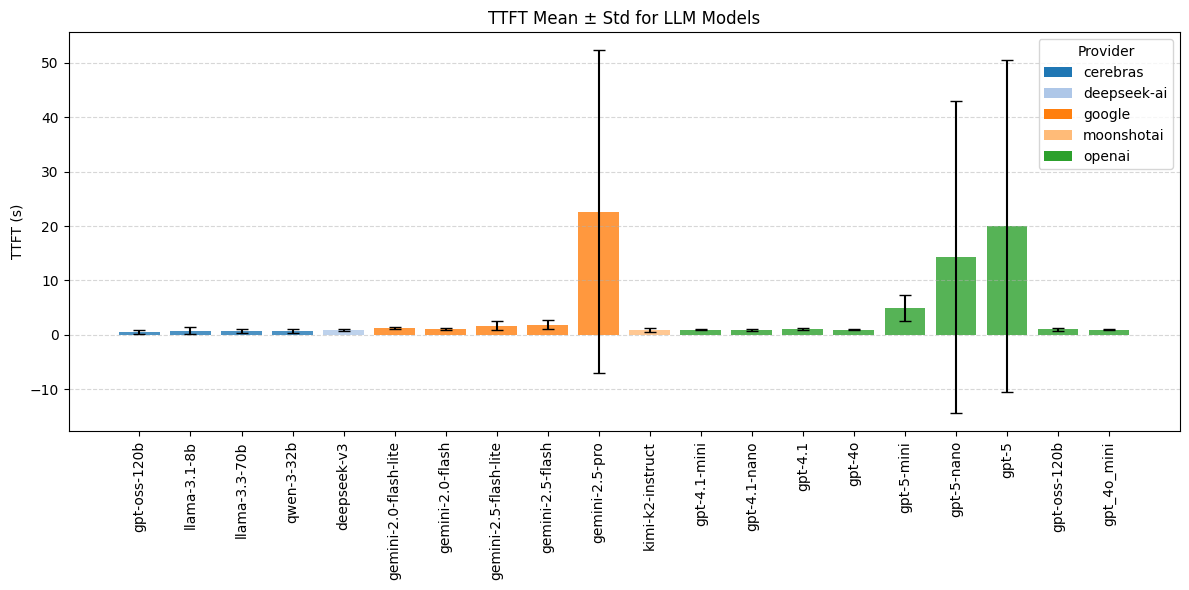

In [29]:
plot_ttft_stats(ttft_stats_df, "TTFT Mean ± Std for LLM Models")

Looks like there are some outliers that makes the picture difficult to perceive. Plot the variant without them.

In [17]:
def drop_outlier_models(df, model_col="model", exclude=["gpt-5", "gpt-5-mini", "gpt-5-nano", "gemini-2.5-pro"]):
    return df[~df[model_col].isin(exclude)].copy()

In [18]:
no_outliers_df = drop_outlier_models(ttft_stats_df)

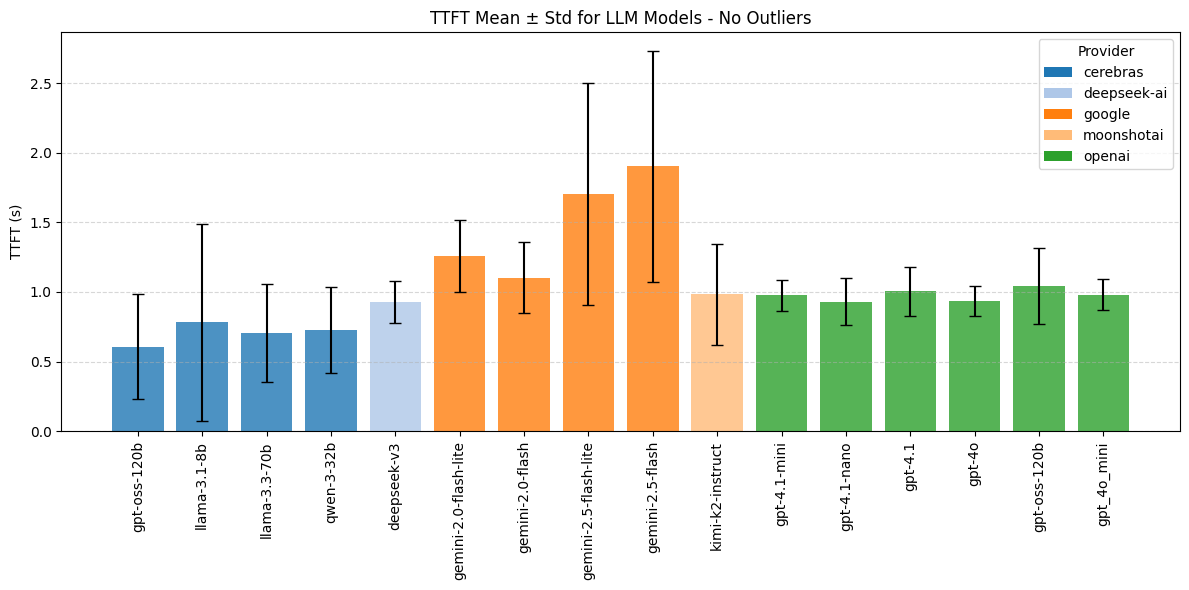

In [30]:
plot_ttft_stats(no_outliers_df, "TTFT Mean ± Std for LLM Models - No Outliers")

### The Tokens per Seconds metric visualization

In [31]:
# Aggregate statistics per model
summary_df = metrics_df.groupby(["provider", "model"])["tokens_per_second"].agg(
    mean="mean",
    std="std",
    min="min",
    max="max"
).reset_index()

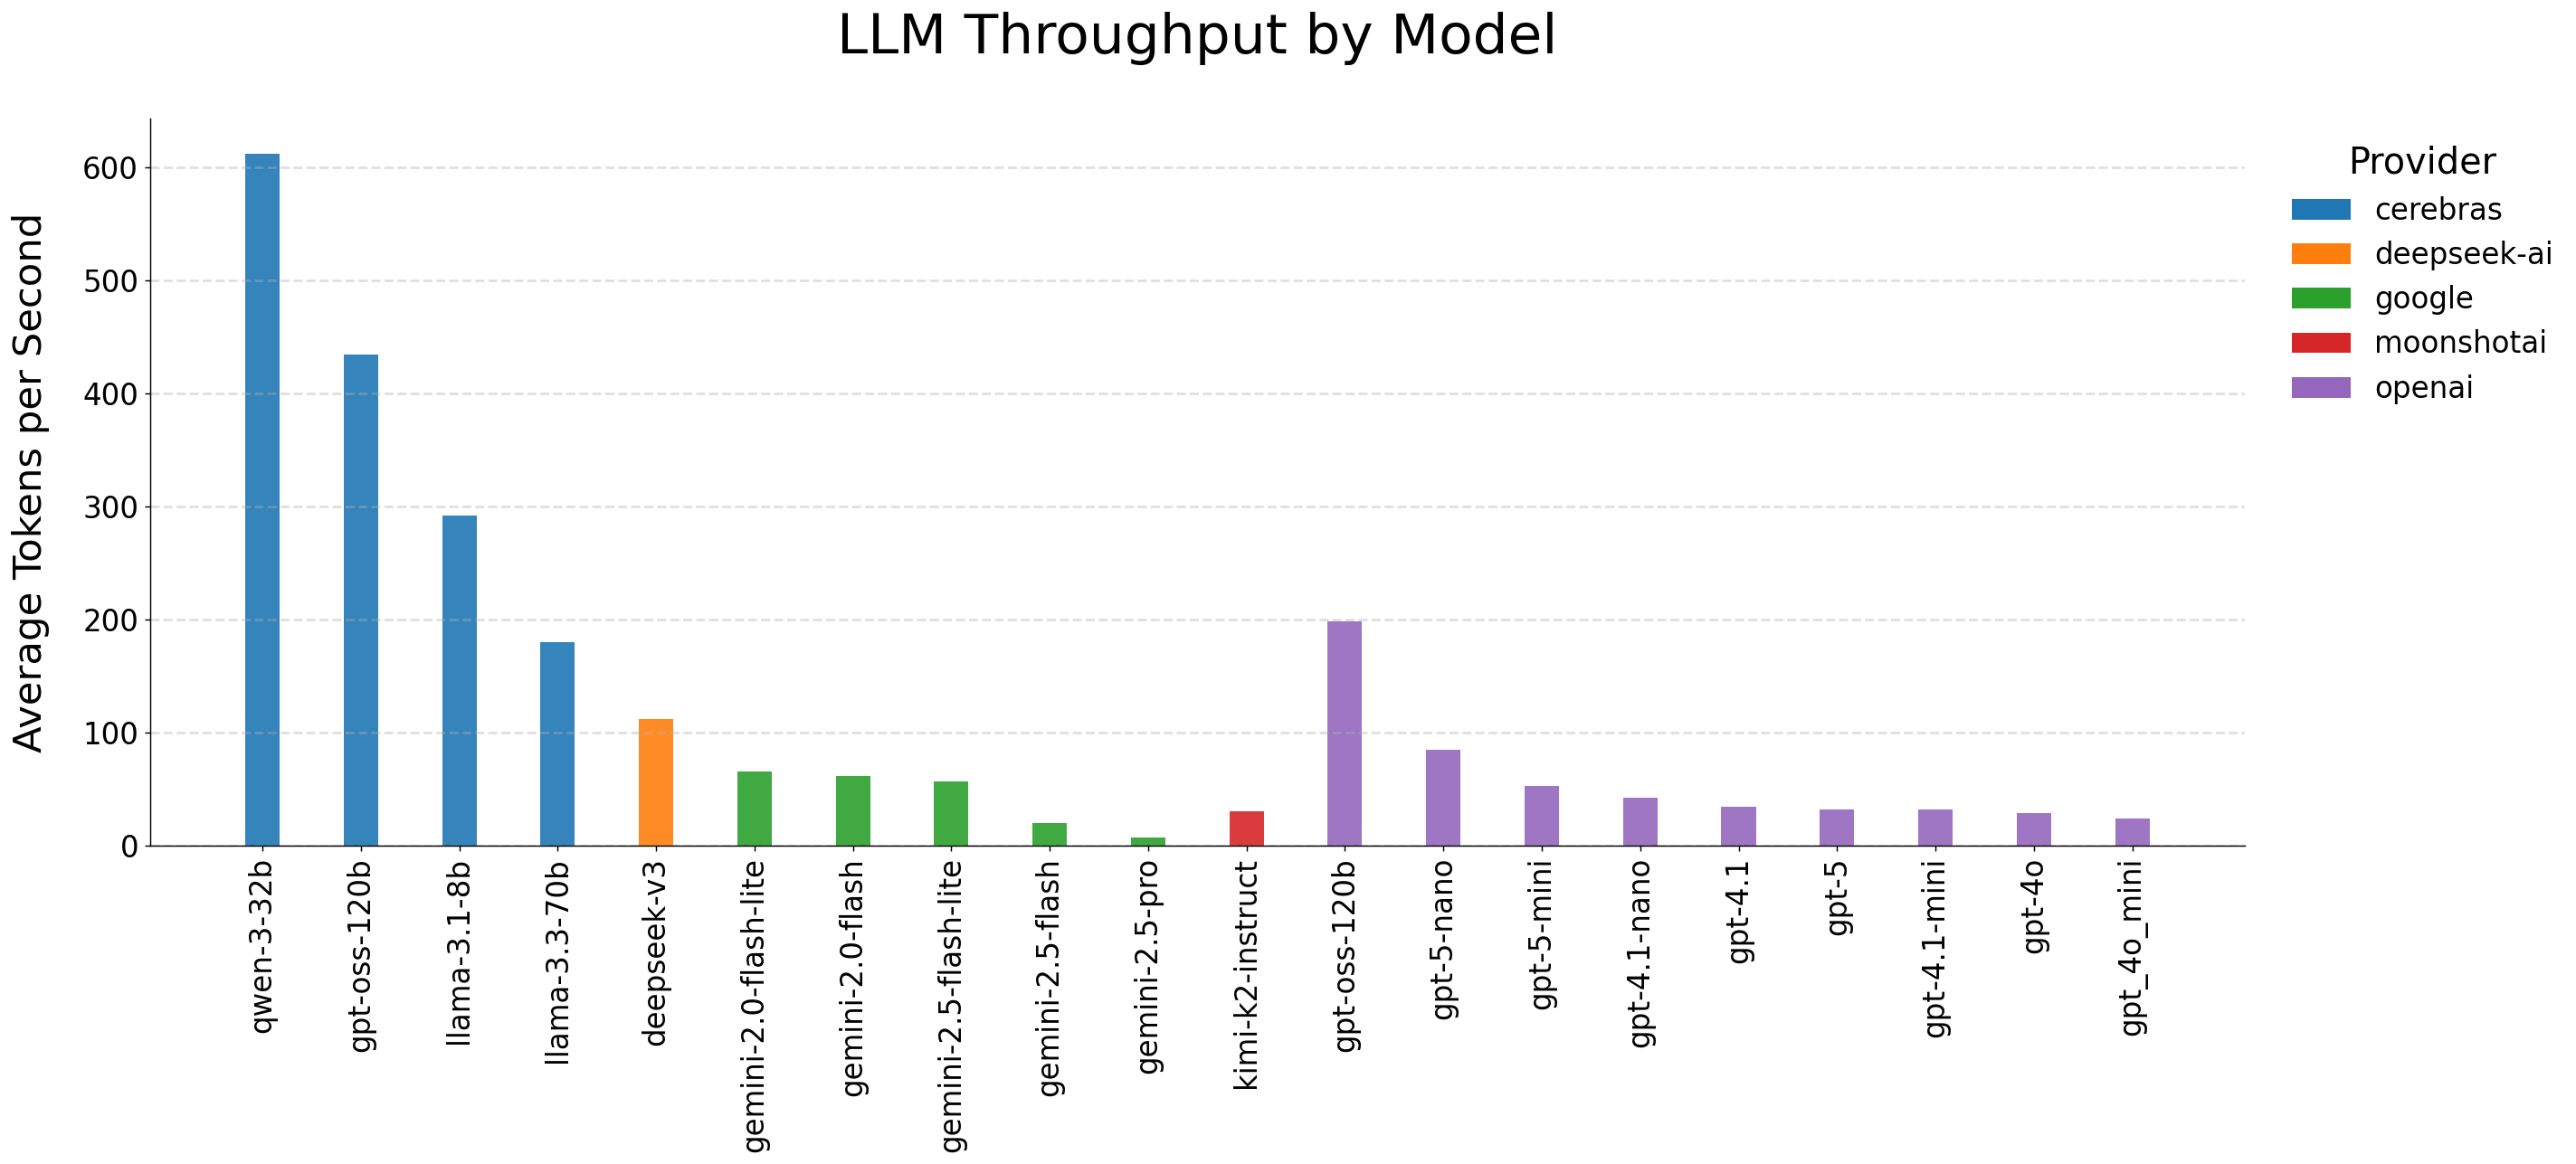

In [32]:
# 1. Prepare data
plot_df = summary_df.sort_values(by=["provider", "mean"], ascending=[True, False])

# 2. Setup Colors
providers = plot_df["provider"].unique()
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_map = {prov: colors[i % len(colors)] for i, prov in enumerate(providers)}

# 3. Canvas & Resolution
# Increased DPI slightly for even better text rendering
fig, ax = plt.subplots(figsize=(22, 10), dpi=130)

# 4. Sequential Plotting
x_pos = np.arange(len(plot_df))
bars = ax.bar(
    x_pos, 
    plot_df["mean"], 
    color=[color_map[p] for p in plot_df["provider"]],
    width=0.35, 
    alpha=0.9
)

# 5. LARGE, BOLD TEXT OVERHAUL
ax.set_xticks(x_pos)
ax.set_xticklabels(
    plot_df["model"], 
    rotation=90, 
    ha="center", 
    fontsize=18    
)

# Y-Axis and Title scaling
ax.set_ylabel("Average Tokens per Second", fontsize=24, labelpad=20)
ax.set_title("LLM Throughput by Model", fontsize=34, pad=40)

# 6. ENHANCED LEGEND (Scaled up)
legend_elements = [Patch(facecolor=color_map[p], label=p) for p in providers]
ax.legend(
    handles=legend_elements, 
    title="Provider", 
    title_fontsize=22, 
    fontsize=18,       
    bbox_to_anchor=(1.01, 1), 
    loc='upper left', 
    frameon=False
)

# 7. ADD GRID
ax.grid(axis="y", linestyle="--", alpha=0.4, linewidth=1.5)

# Modern Cleanup
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='y', labelsize=18) # Make the numbers on the Y-axis larger too

plt.tight_layout()
plt.show()


### Tokens per Seconds against TTFT

The scatter plot illustrating the relationship between model latency (TTFT) and throughput (tokens per second). Each point represents a model, colored by provider.<br>
Models located in the bottom-right region combine low latency and high throughput and can be considered more favorable for real-time applications. This visualization helps identify whether a latency–throughput trade-off is present or whether certain models outperform others across both dimensions.

In [25]:
def plot_tokens_vs_ttft(df, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df,
        x="tokens_per_second",
        y="ttft",
        hue="model",
        style="provider",
        s=100,
    )
    plt.xlabel("Tokens per Second")
    plt.ylabel("TTFT (Time to First Token)")
    plt.title(title)
    plt.grid(True)  
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

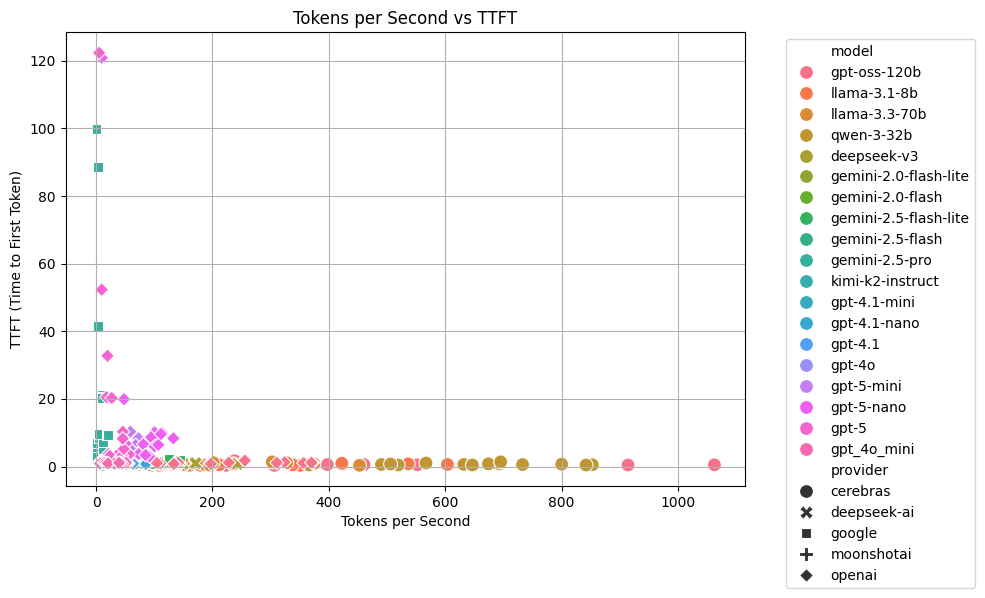

In [26]:
plot_tokens_vs_ttft(metrics_df, "Tokens per Second vs TTFT")

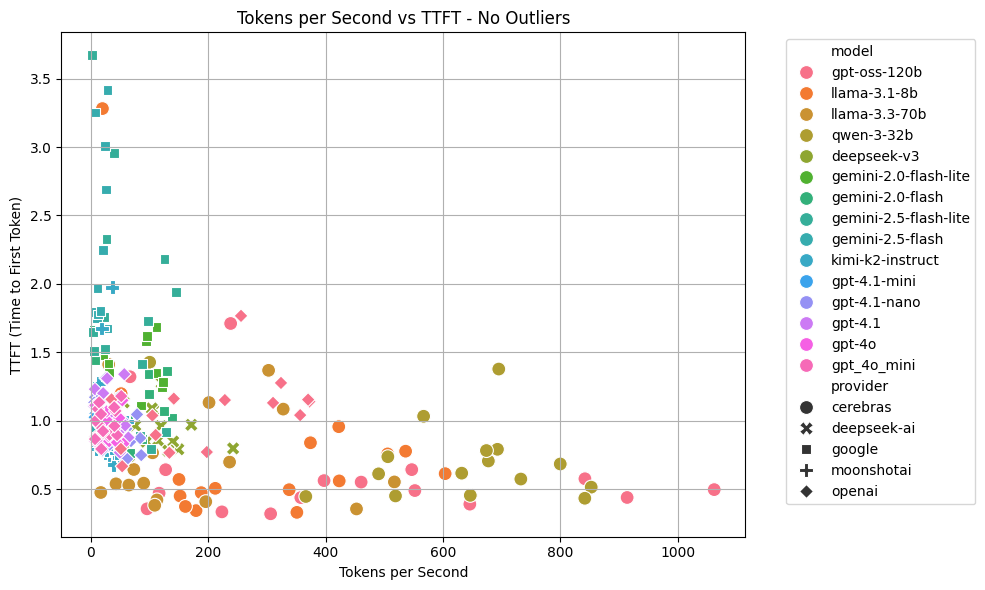

In [27]:
no_outliers_metrics_df = drop_outlier_models(metrics_df)
plot_tokens_vs_ttft(no_outliers_metrics_df, "Tokens per Second vs TTFT - No Outliers")

### LLM Models verbosity analysis

#### All the models were responding on the same set of questions:

<b>1. Simple Factual Questions</b>
- What is the capital of France?
- Who won the last World Cup?
- How many planets are in our solar system?

<b>2. Reasoning / Math</b>
- If I have three apples and give two away, how many are left?
- A train leaves the station at 9 a.m. going 60 kilometers per hour. When will it have traveled 180 kilometers?
- If I double a number and then add five, I get 21. What is the number?

<b>3. Short Summaries</b>
- Tell me about your favorite movie in one sentence.
- Explain what a rainbow is in simple words.
- Summarize what happened in the news today.

<b>4. Creativity / Storytelling</b>
- Tell me a short story about a talking dog.
- Invent a new holiday and explain how people celebrate it.
- Describe a futuristic car that can fly.

<b>5. Opinions / Debates</b>
- What is better, tea or coffee, and why?
- Is it better to live in the city or in the countryside?
- Should schools have longer vacations?

<b>Qualitative observations:</b>
- LLM inference not only dominated end-to-end latency but also was the primary source of TimedOut exceptions.

- Timeout frequency positively correlated with output length.

- Model verbosity varied significantly across LLMs and depended on prompt category Creativity/Storytelling and Opinions/Debates produced the longest responses.

- Explicit length constraints (“in ten sentences”, “briefly”, etc.) reduced verbosity but did not strictly enforce token limits.

- Reasoning/Math responses were generally correct but hard to follow in voice form due to mathematical notation.

- Markdown and other formatting artifacts were vocalized by TTS, degrading speech naturalness.

These findings suggest the need for intermediate post-processing between LLM and TTS, including formatting cleanup, math normalization, and optional verbosity control.

### The completion_tokens metrics by the models and the separete questions 

In [181]:
questions =[
    "Session Prompt: Greet the user and offer your assistance.",
    "What is the capital of France?",
    "Who won the last World Cup?",
    "How many planets are in our solar system?",
    "If I have three apples and give two away, how many are left?",
    "A train leaves the station at 9 a.m. going 60 kilometers per hour. When will it have traveled 180 kilometers?",
    "If I double a number and then add five, I get 21. What is the number?",
    "Tell me about your favorite movie in one sentence.",
    "Explain what a rainbow is in simple words",
    "Summarize what happened in the news today.",
    "Tell me a short story about a talking dog.",
    "Invent a new holiday and explain how people celebrate it.",
    "Describe a futuristic car that can fly.",
    "What is better, tea or coffee, and why?",
    "Is it better to live in the city or in the countryside?",
    "Should schools have longer vacations?"
]

In [186]:
quest_df_rows = [[] for q in questions]

In [187]:
for provider_dir in logs_path.iterdir():
    if provider_dir.is_dir():
        provider = provider_dir.name  # subdirectory name as provider
        for model_file in provider_dir.iterdir():
            if model_file.is_file() and model_file.suffix == ".csv":
                df = pd.read_csv(model_file)
                model = model_file.stem
                
                for index, row in df.iterrows():
                    model_row = {
                        "provider": provider,
                        "model": model,
                        "completion_tokens": row["completion_tokens"]    
                    }
                                        
                    quest_df_rows[index].append(model_row)                    

In [188]:
quest_df_columns=["provider", "model", "completion_tokens"]
quest_dfs = [pd.DataFrame(quest_df_rows[i], columns=quest_df_columns) for i,q in enumerate(questions)]

In [175]:
def plot_completion_tokens(df, question):
    if df.empty: return

    # 1. SHARPNESS & DATA PREP
    plt.rcParams['figure.dpi'] = 120 
    plot_df = df.copy().sort_values(by=["provider", "completion_tokens"], ascending=[True, False])
    
    providers = plot_df["provider"].unique()
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    color_map = {p: colors[i % len(colors)] for i, p in enumerate(providers)}

    # 2. DYNAMIC WIDTH: Adjusts width based on number of bars 
    # to prevent them from looking too thin or too spread out.
    dynamic_width = max(14, len(plot_df) * 0.7) 
    fig, ax = plt.subplots(figsize=(dynamic_width, 9))

    # 3. SEQUENTIAL BARS (width=0.5 for better proportions)
    x_pos = np.arange(len(plot_df))
    bars = ax.bar(
        x_pos, 
        plot_df["completion_tokens"], 
        color=[color_map[p] for p in plot_df["provider"]], 
        width=0.5, 
        alpha=0.9
    )

    # 4. WRAP TITLE & FIXED PARAMETER: Use 'linespacing'
    # This prevents the long question from squashing the plot area
    wrapped_title = "\n".join(textwrap.wrap(f"Question: {question}", width=70))
    ax.set_title(wrapped_title, fontsize=18, pad=35, linespacing=1.2)

    # 5. TEXT & LABELS
    ax.set_xticks(x_pos)
    ax.set_xticklabels(plot_df["model"], rotation=90, fontsize=12, )
    ax.tick_params(axis='y', labelsize=12)
    ax.set_ylabel("Completion Tokens", fontsize=14)

    # Add numeric labels on top of bars
    ax.bar_label(bars, padding=3, fontsize=10)

    # 6. LEGEND & BUFFER
    # Add 15% space at the top so the bar labels don't touch the title
    ax.set_ylim(0, plot_df["completion_tokens"].max() * 1.15)
    
    legend_elements = [Patch(facecolor=color_map[p], label=p) for p in providers]
    ax.legend(handles=legend_elements, title="Provider", 
               bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)

    ax.grid(axis="y", linestyle="--", alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

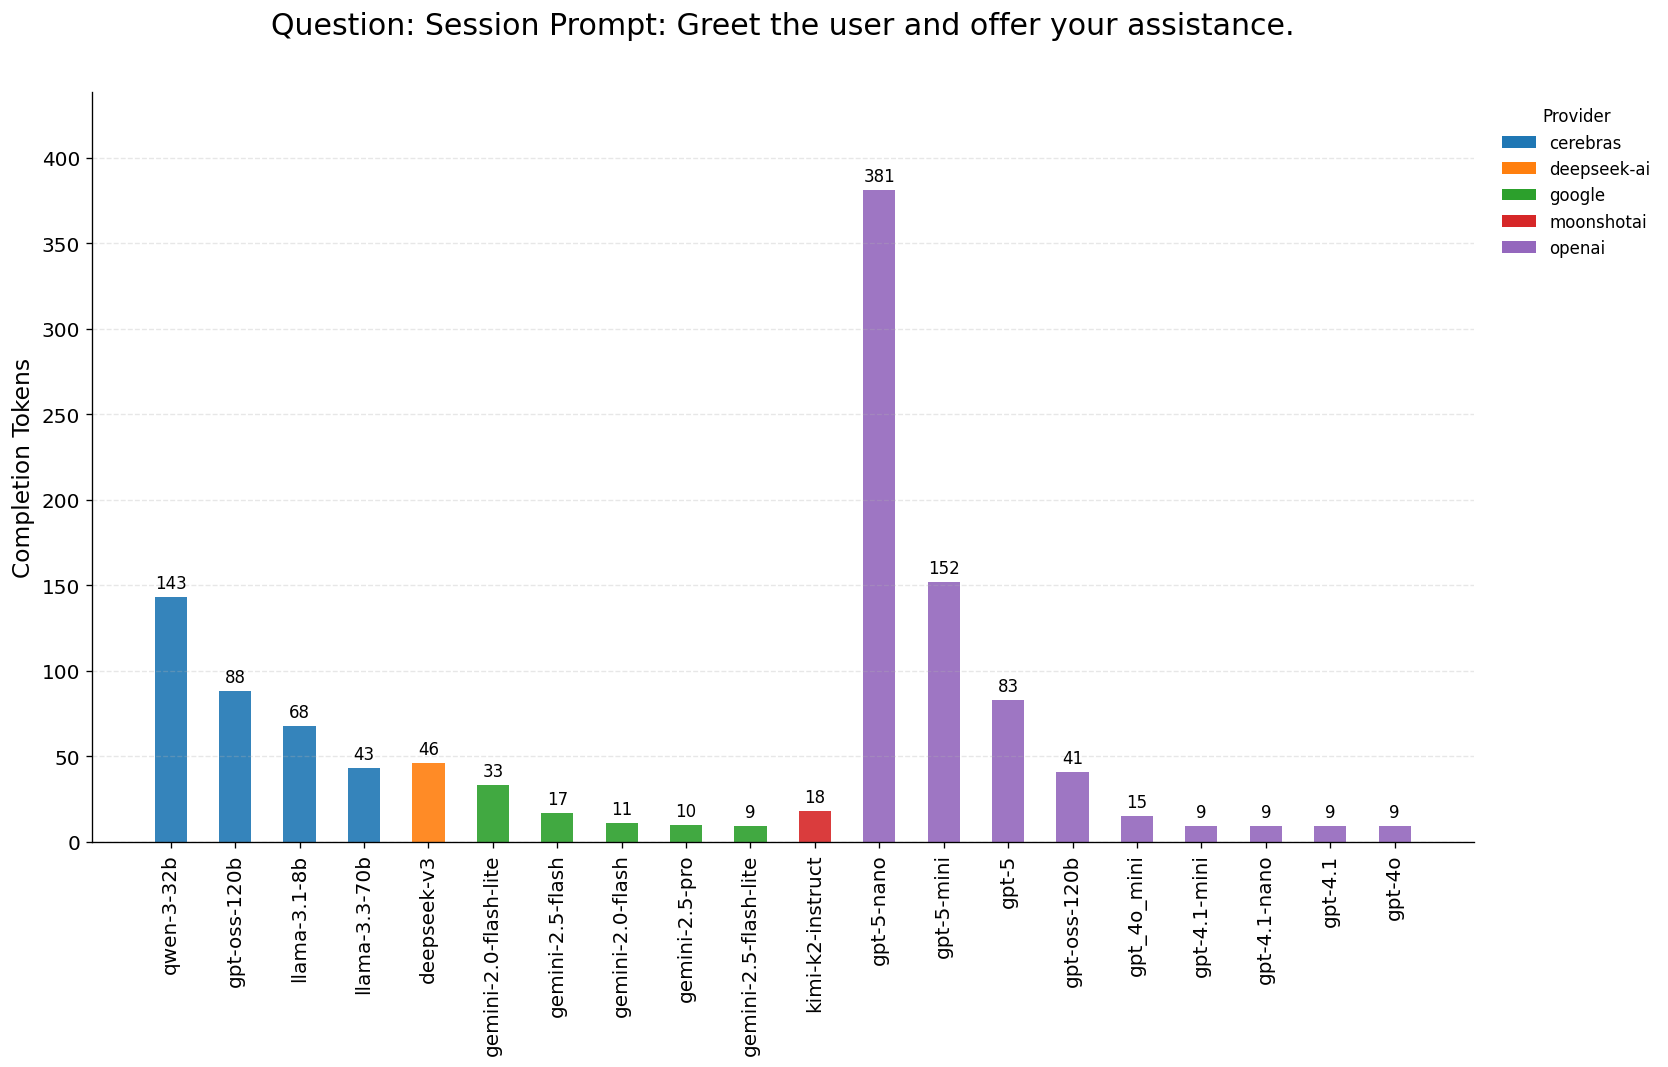

In [176]:
plot_completion_tokens(quest_dfs[0], questions[0])

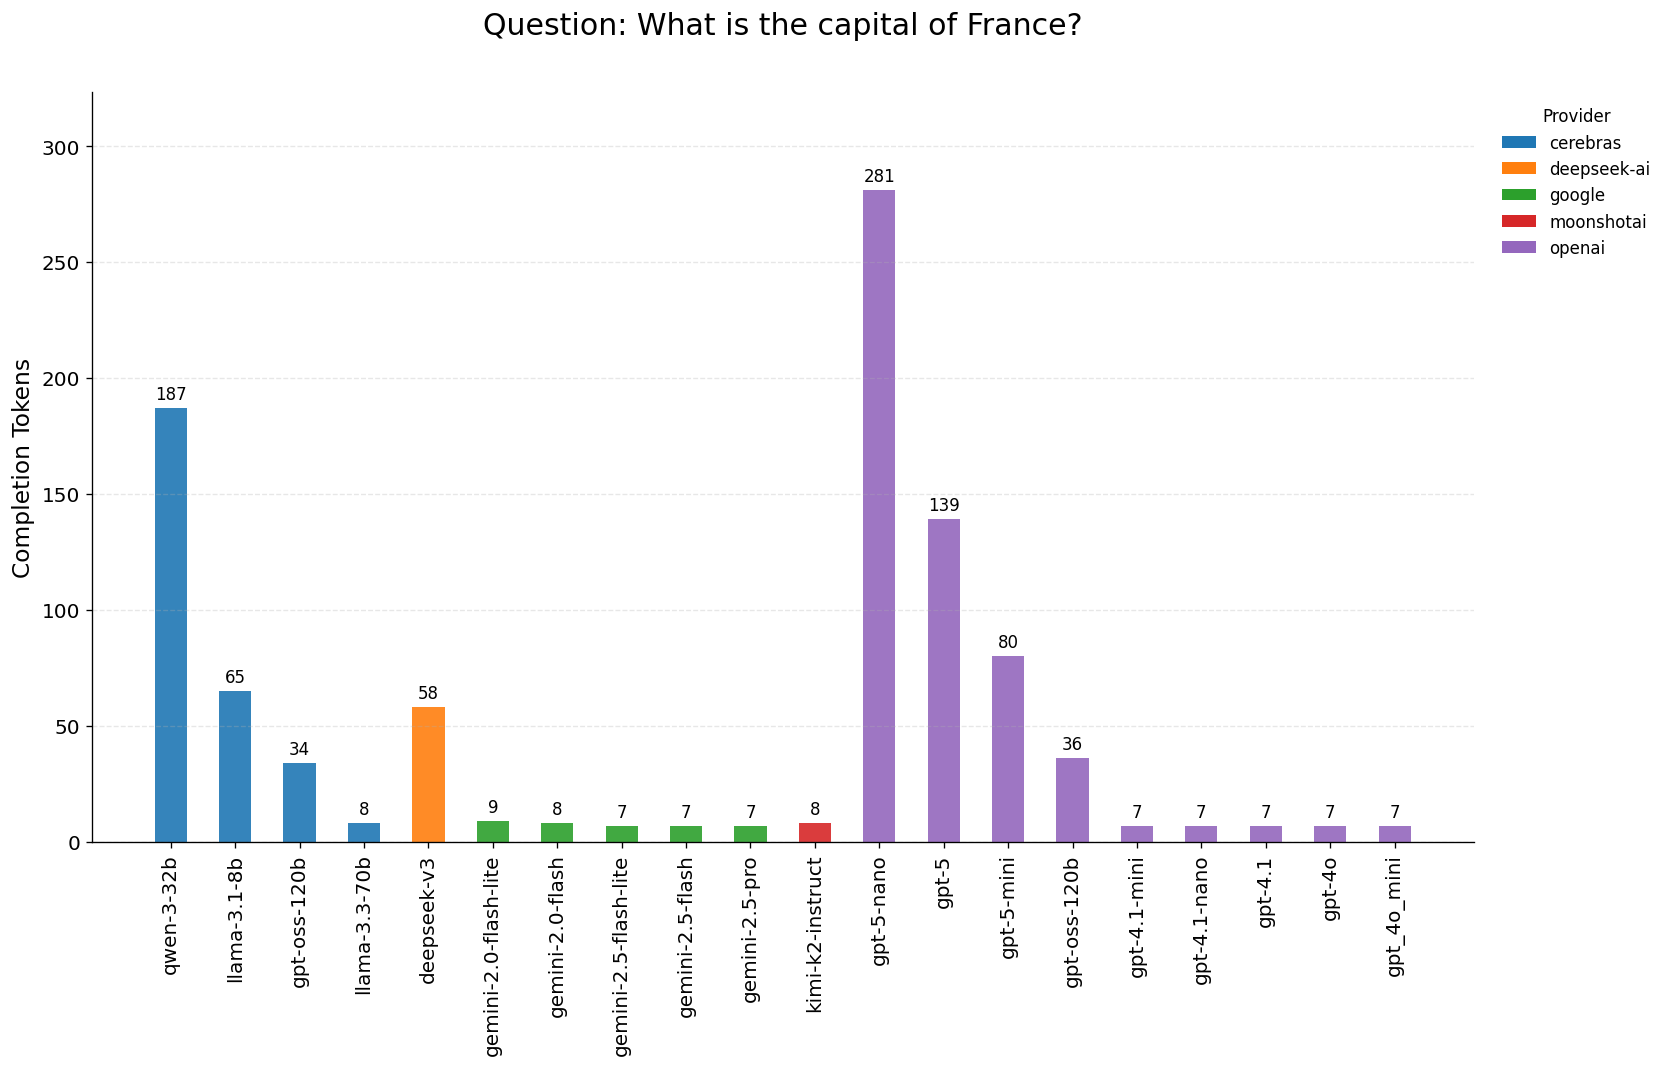

In [160]:
plot_completion_tokens(quest_dfs[1], questions[1])

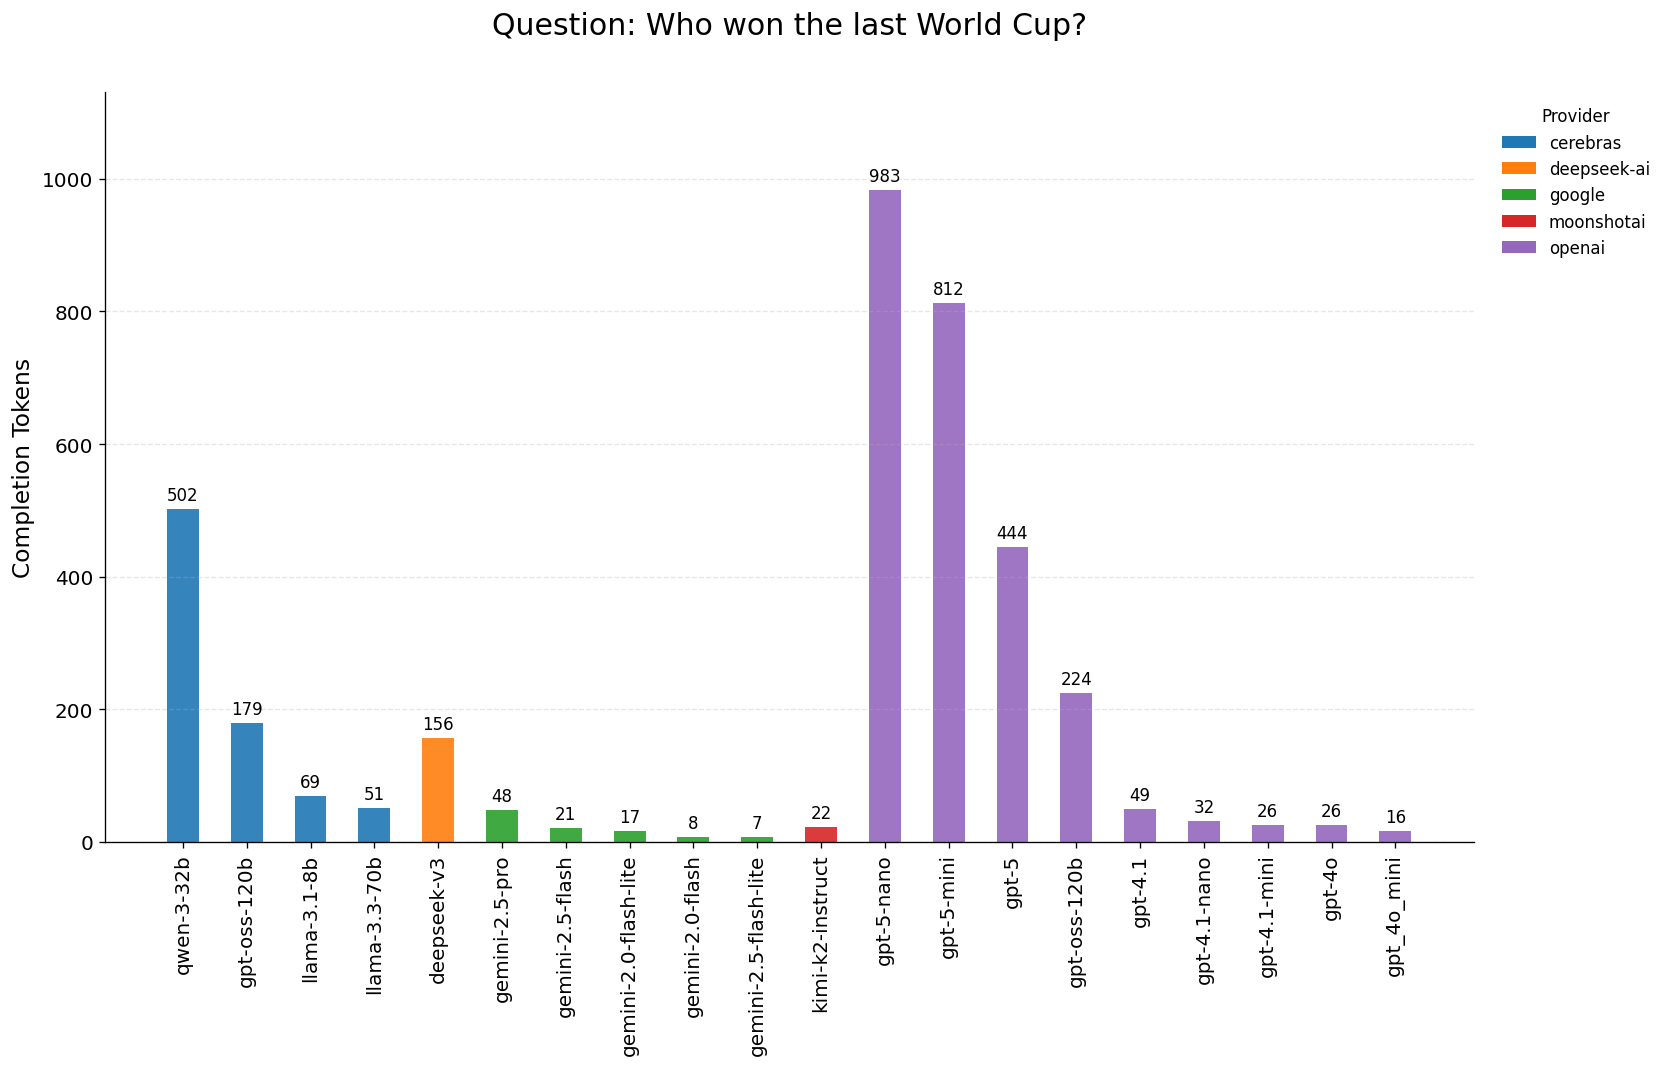

In [161]:
plot_completion_tokens(quest_dfs[2], questions[2])

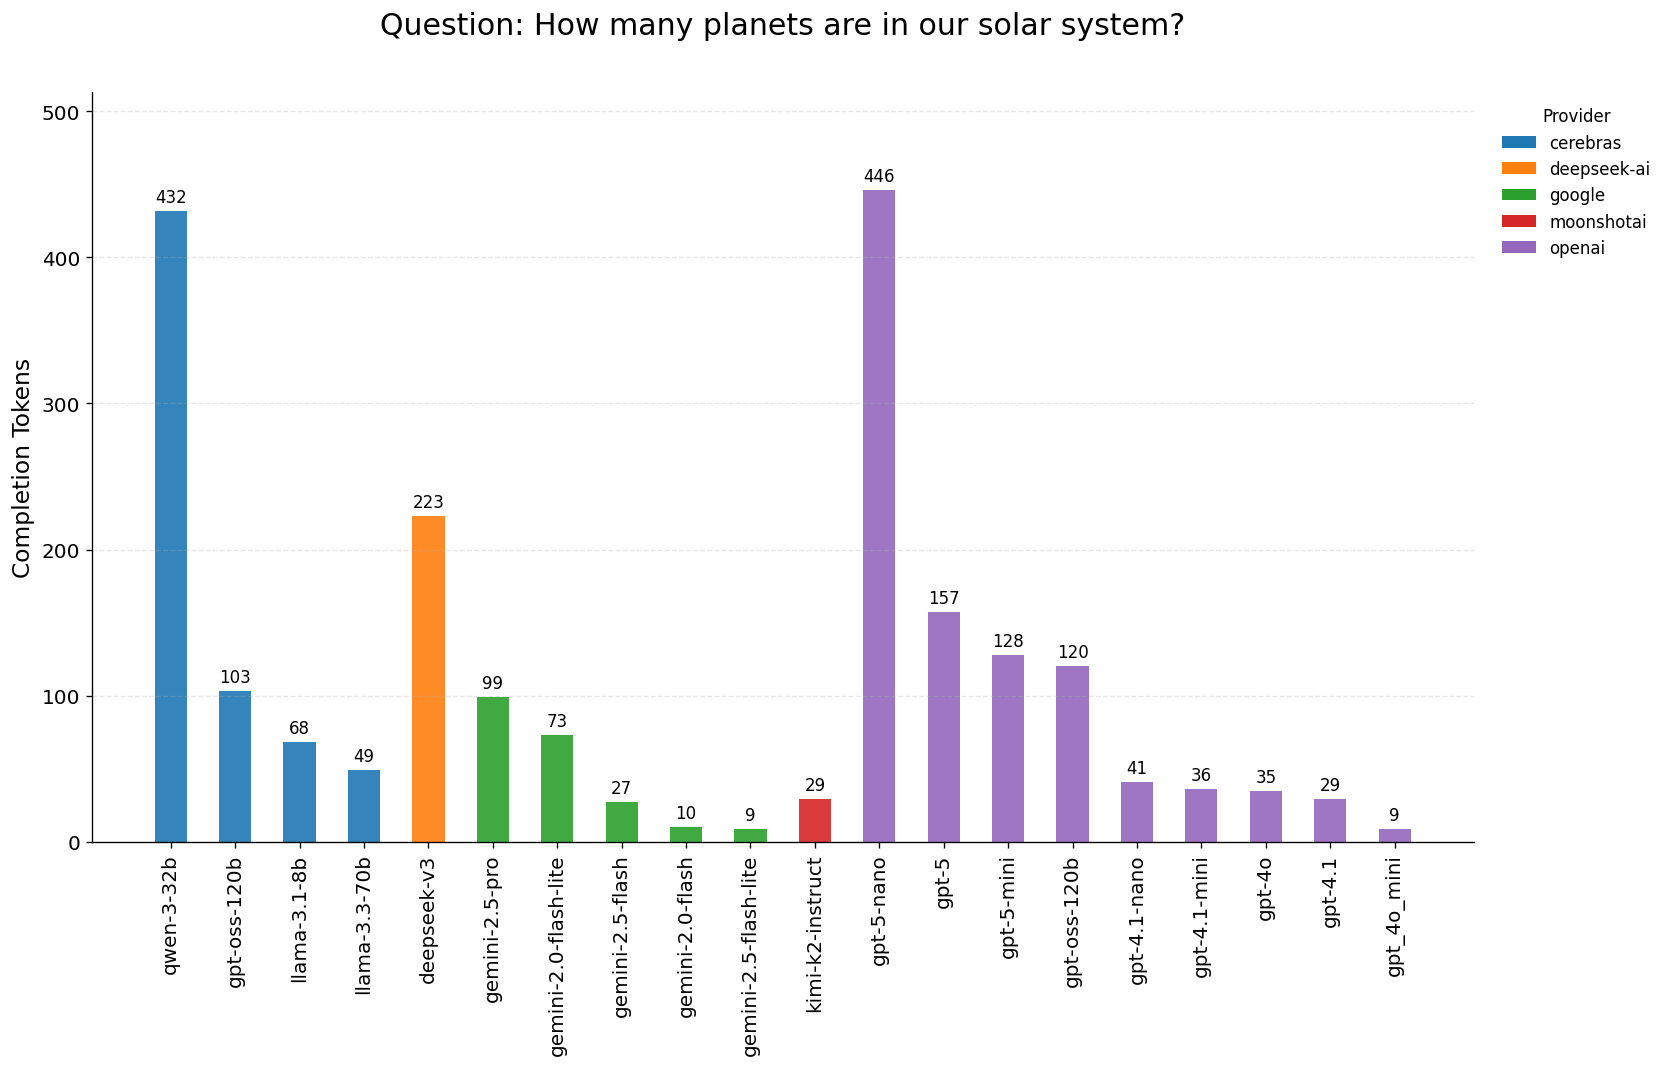

In [162]:
plot_completion_tokens(quest_dfs[3], questions[3])

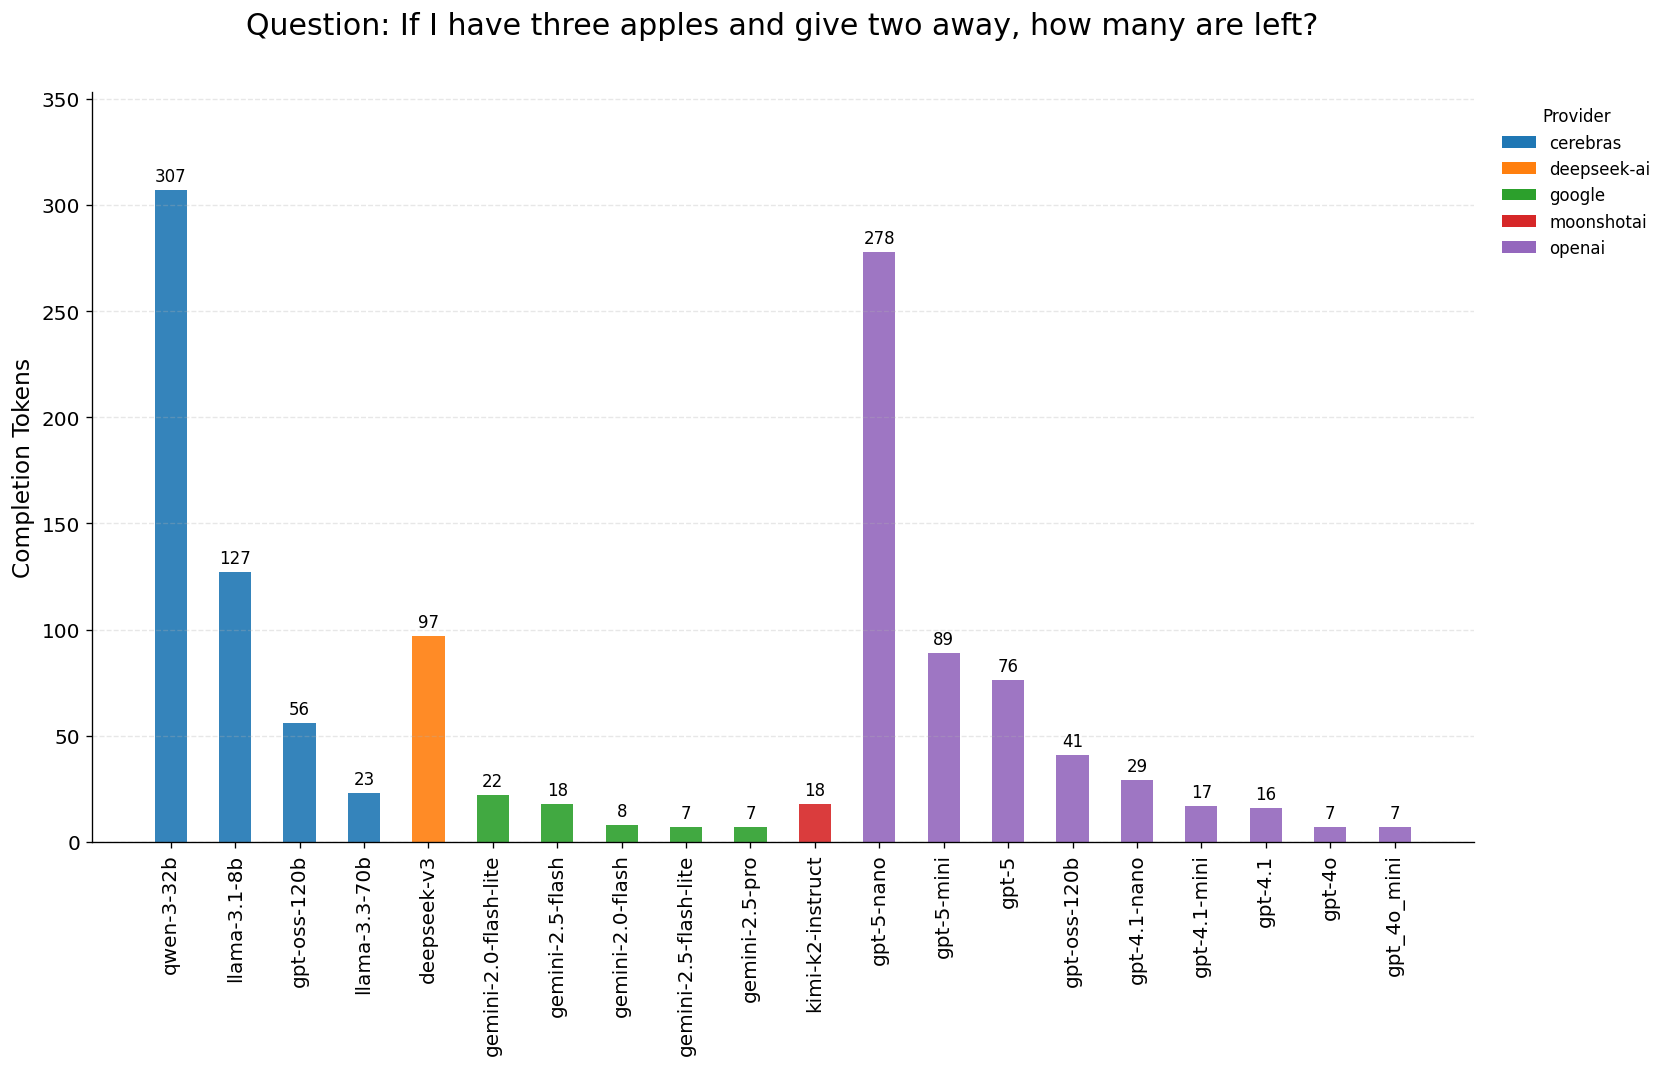

In [163]:
plot_completion_tokens(quest_dfs[4], questions[4])

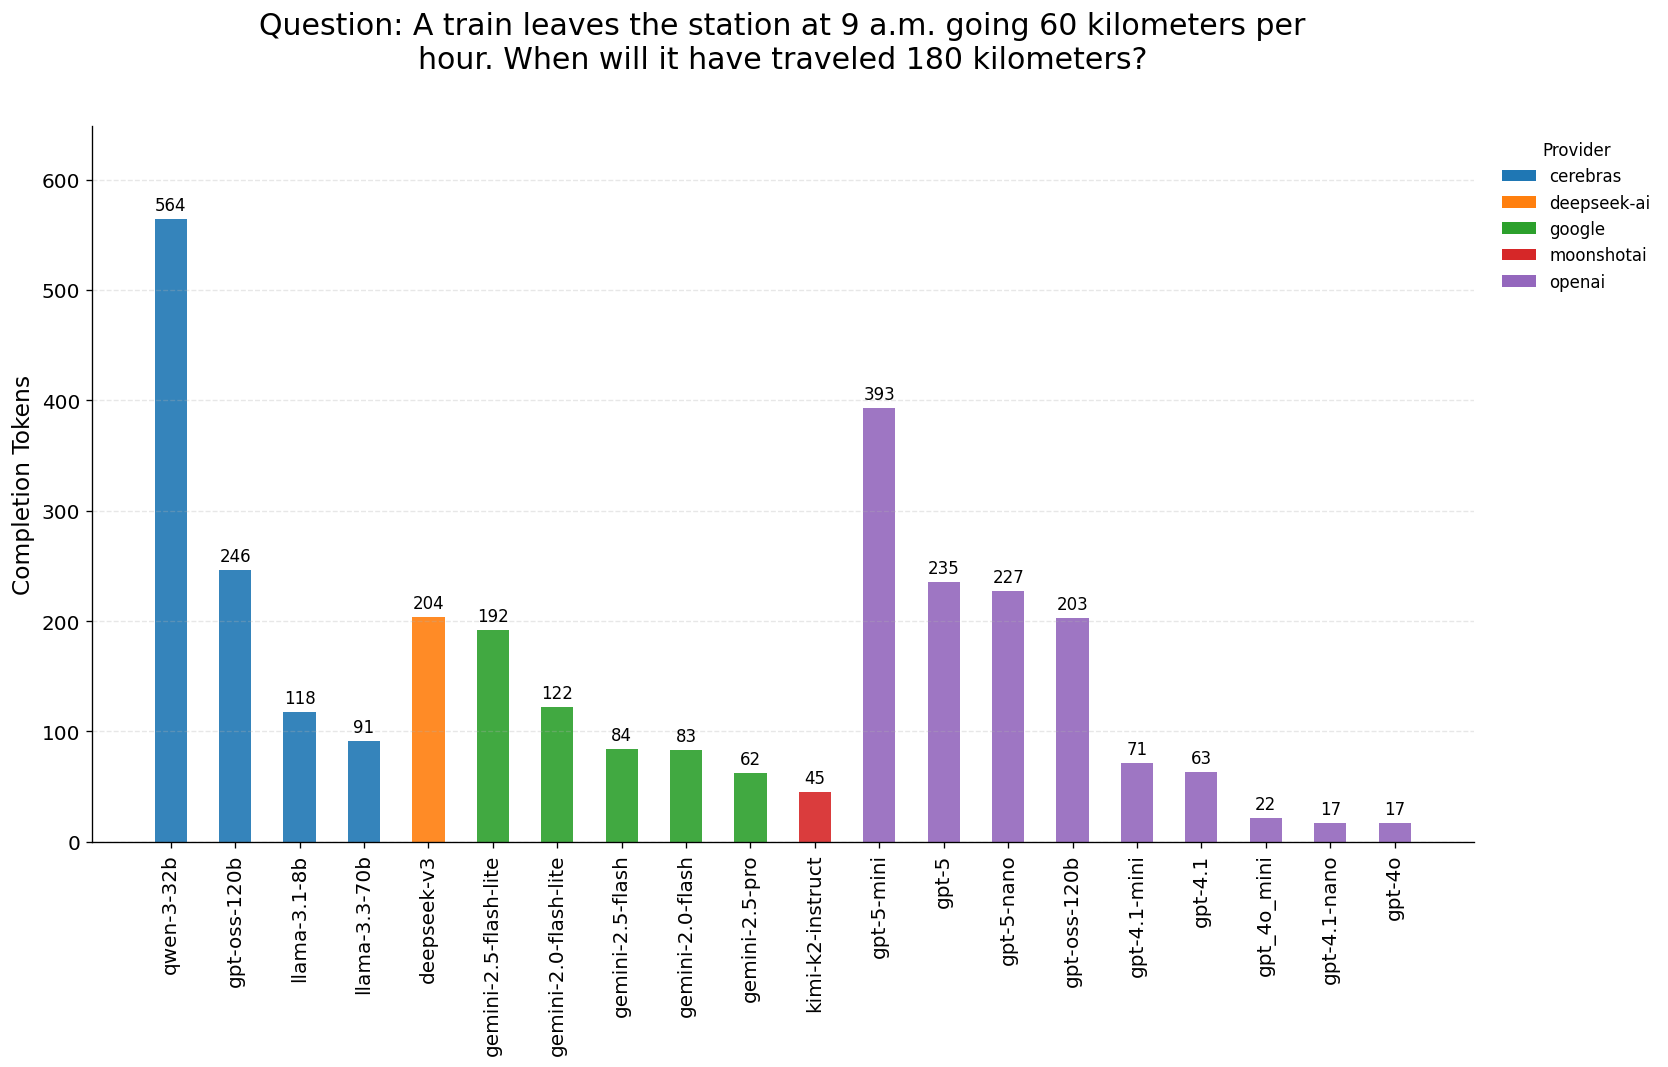

In [164]:
plot_question_results(quest_dfs[5], questions[5])

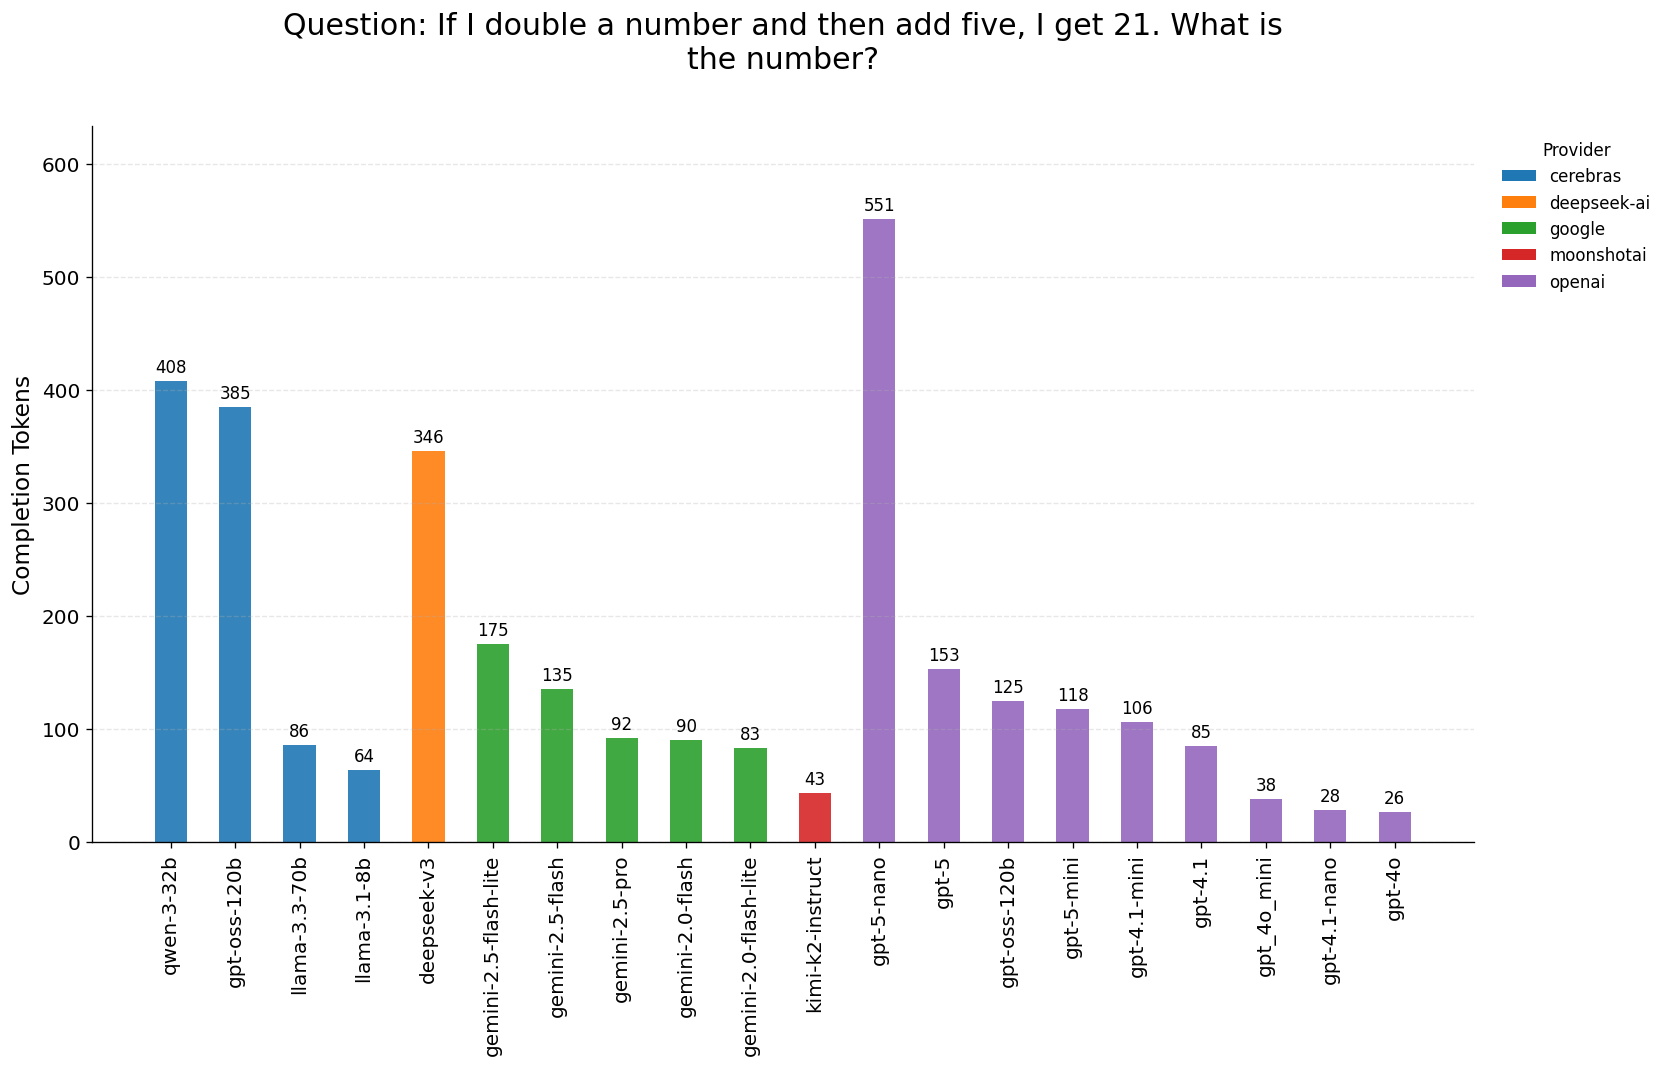

In [189]:
plot_completion_tokens(quest_dfs[6], questions[6])

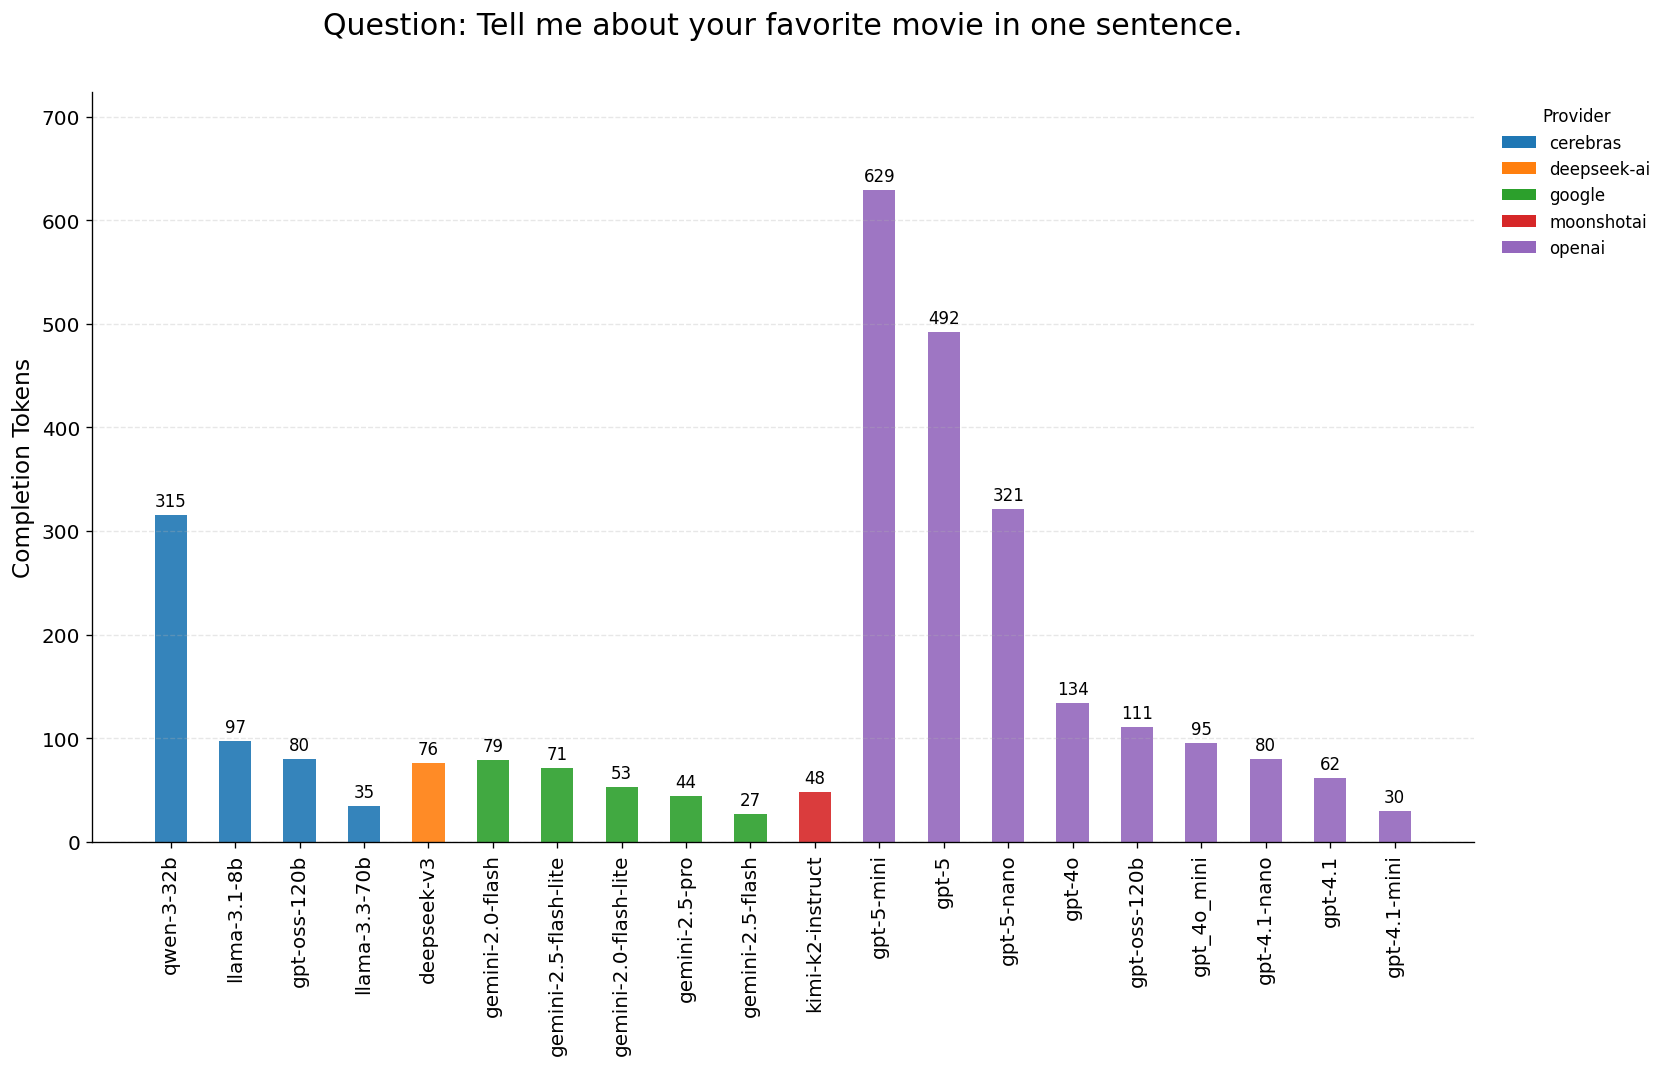

In [166]:
plot_completion_tokens(quest_dfs[7], questions[7])

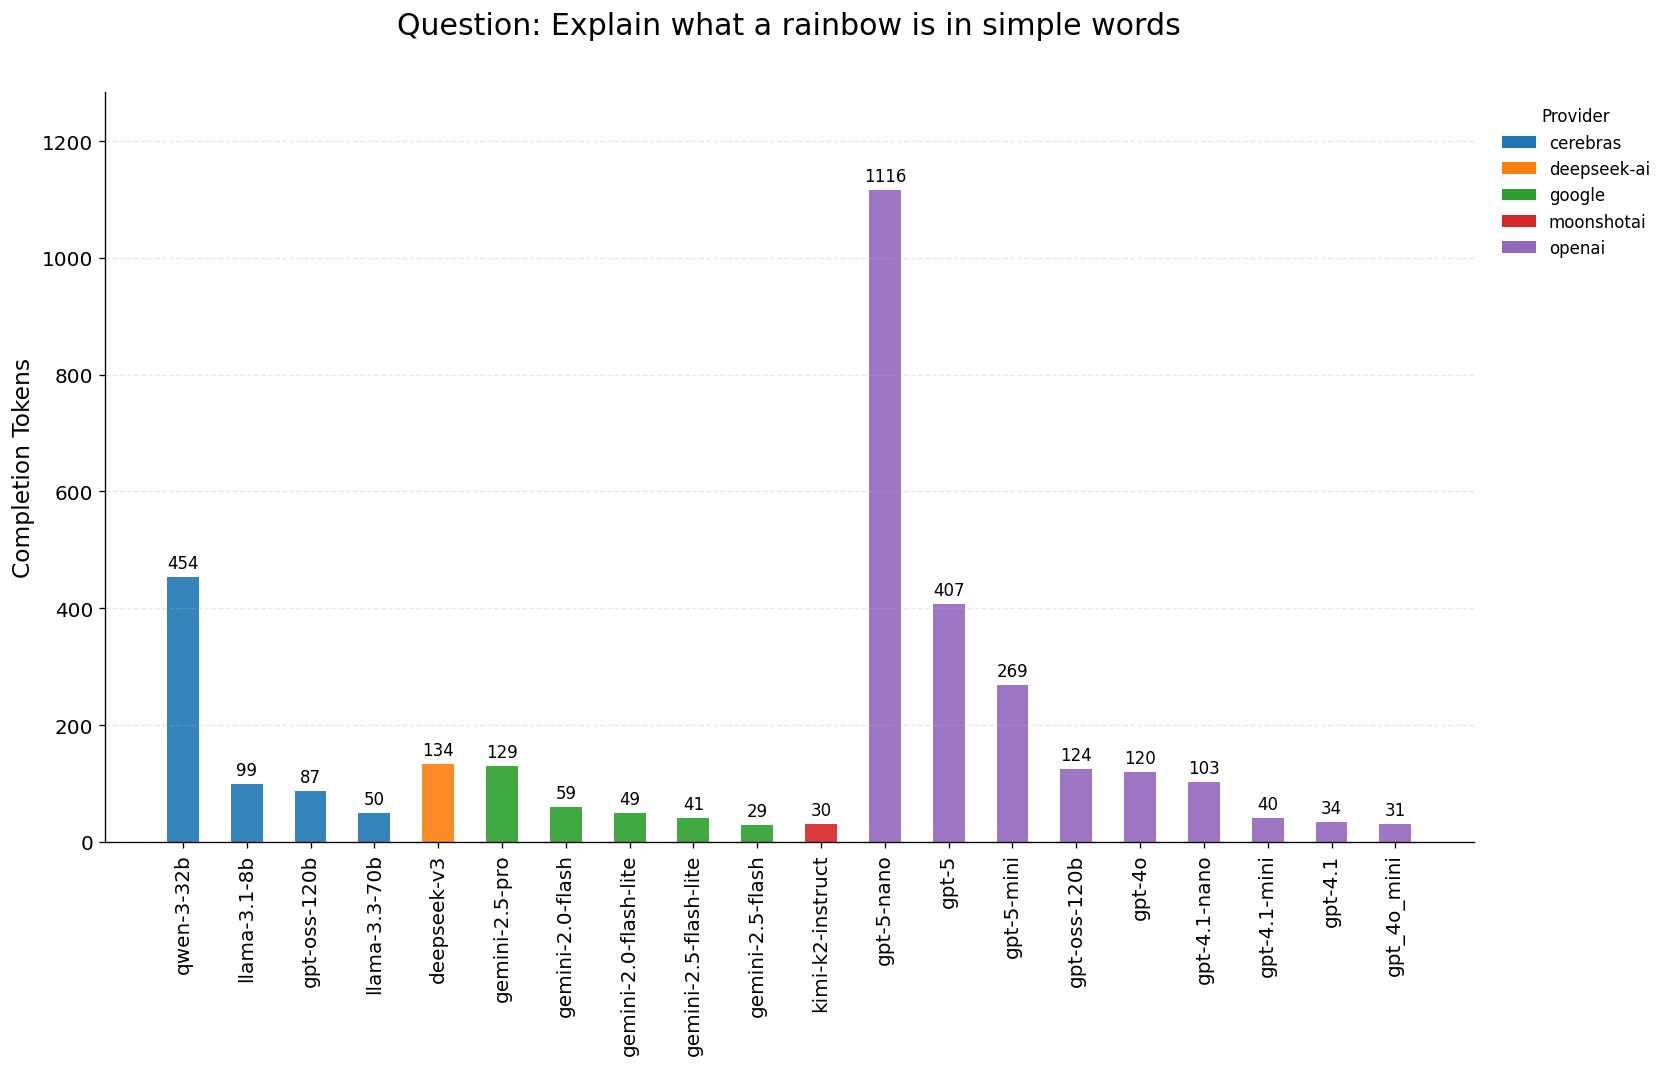

In [167]:
plot_completion_tokens(quest_dfs[8], questions[8])

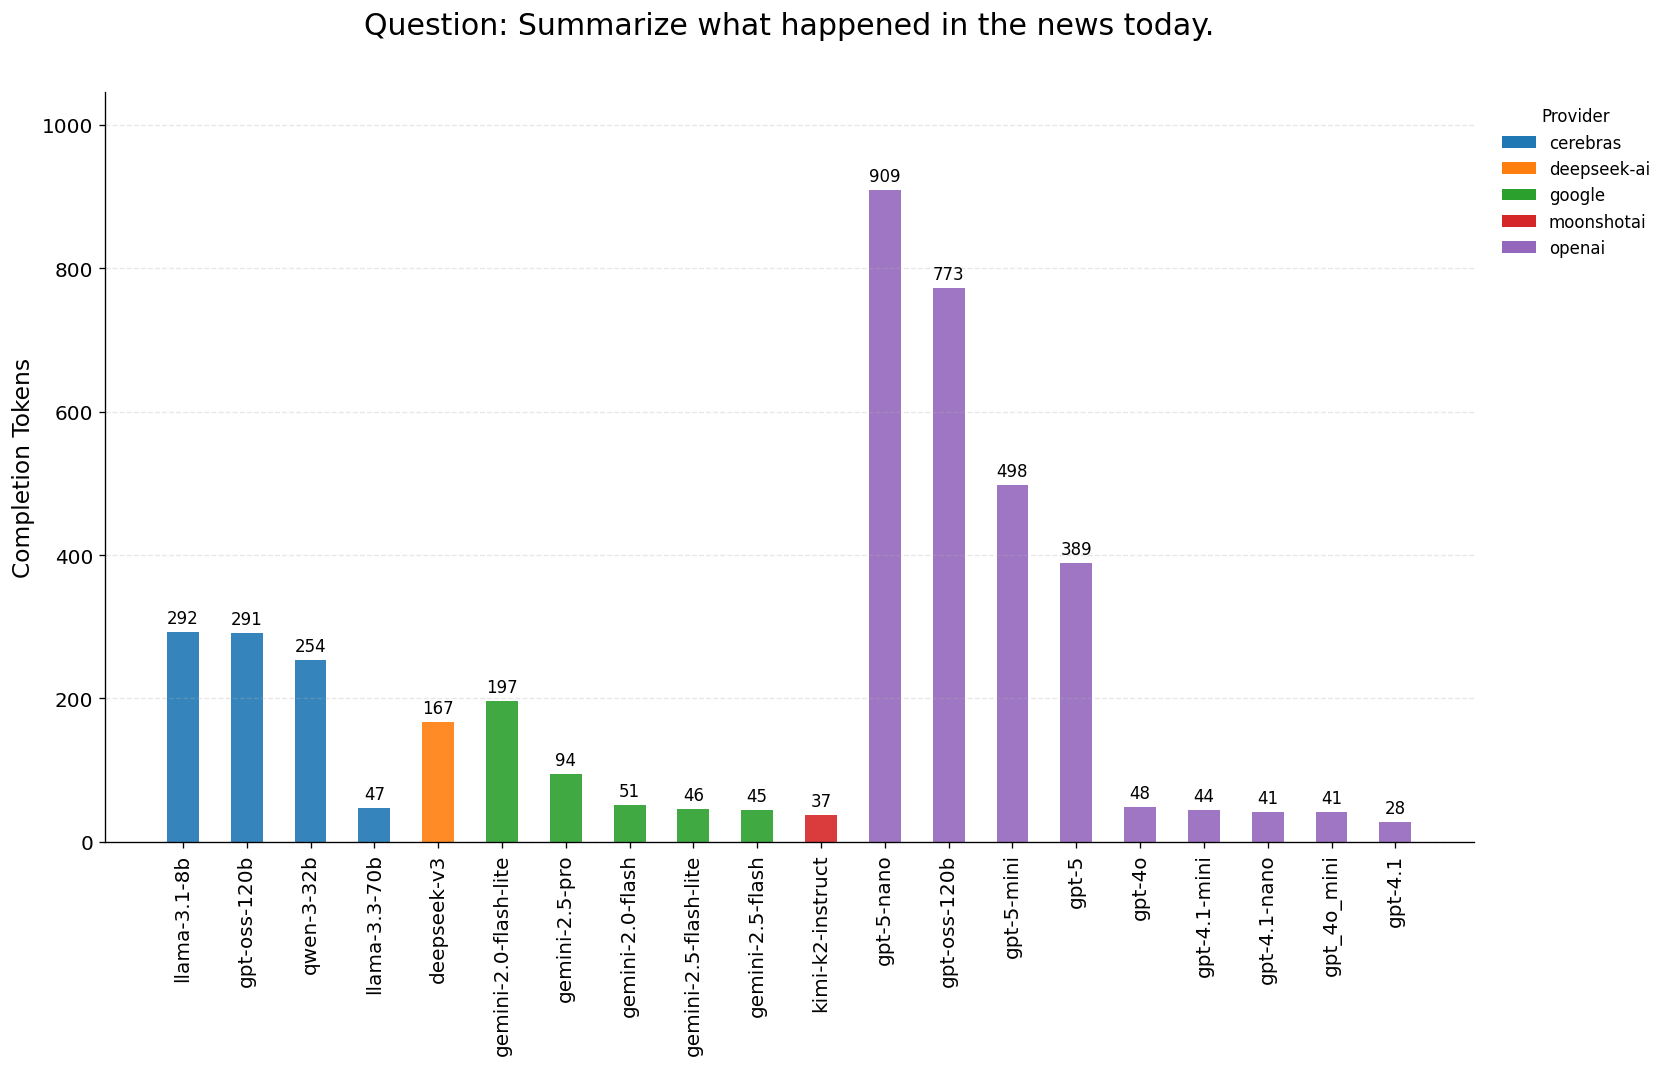

In [168]:
plot_completion_tokens(quest_dfs[9], questions[9])

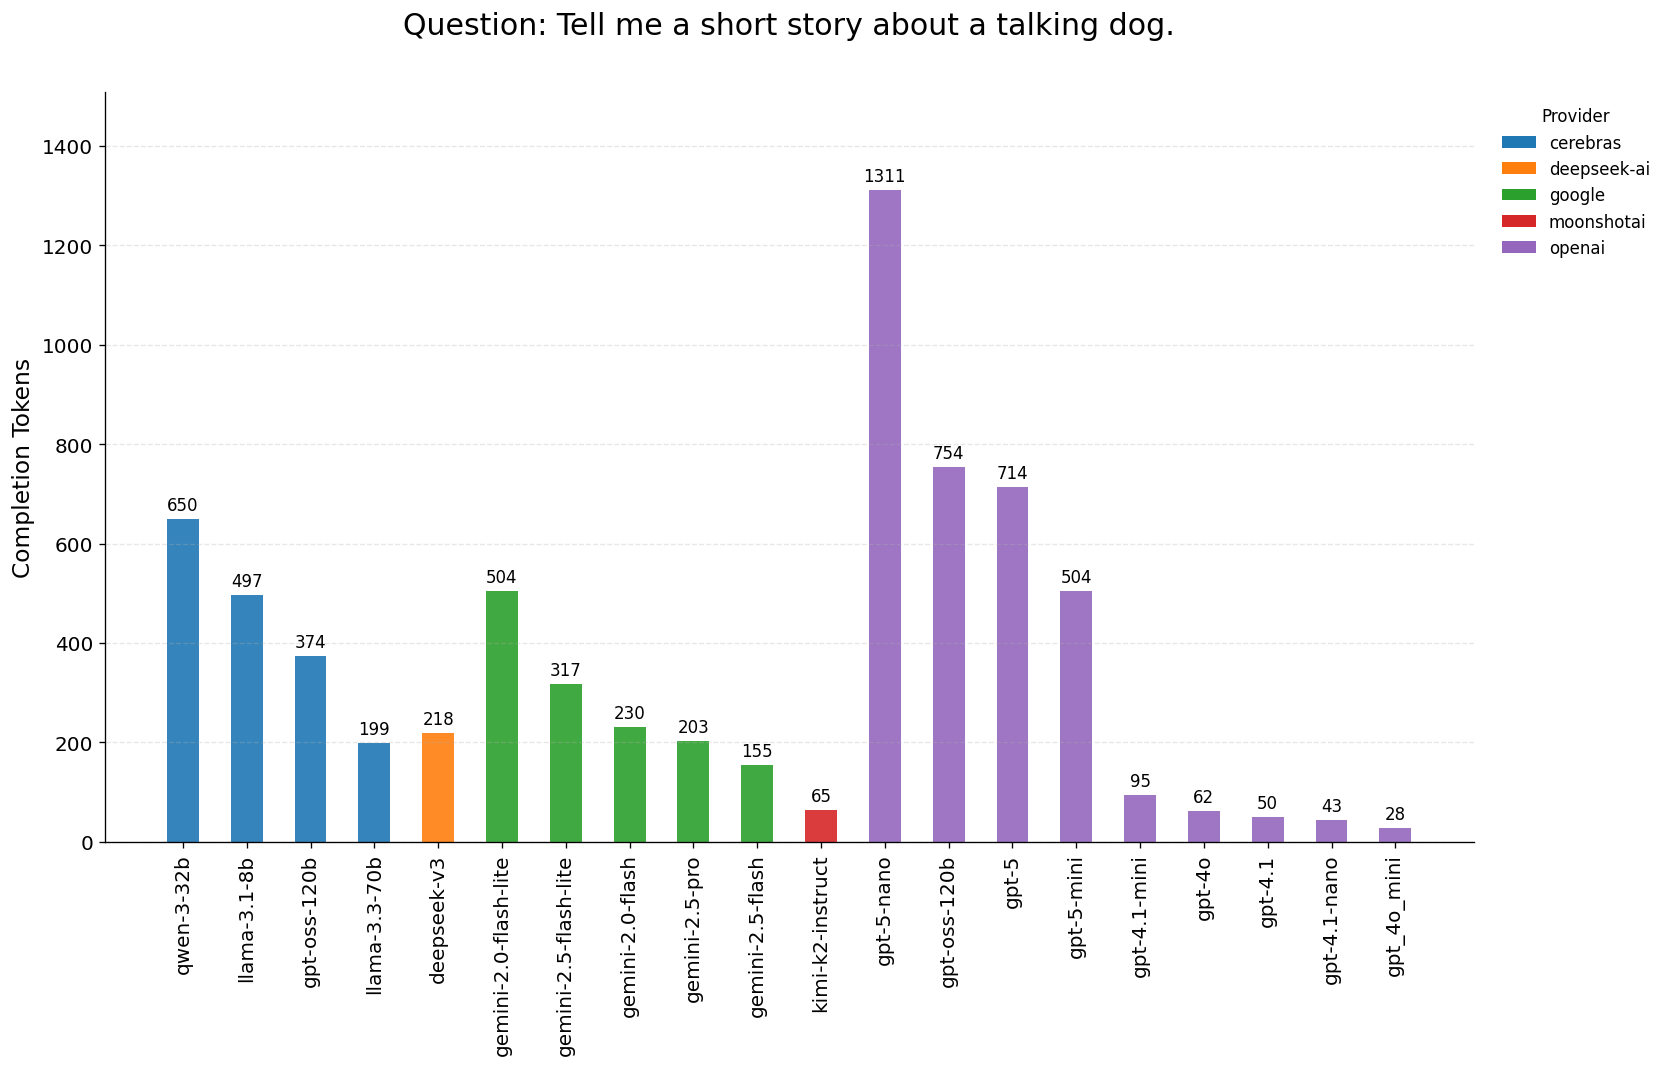

In [169]:
plot_completion_tokens(quest_dfs[10], questions[10])

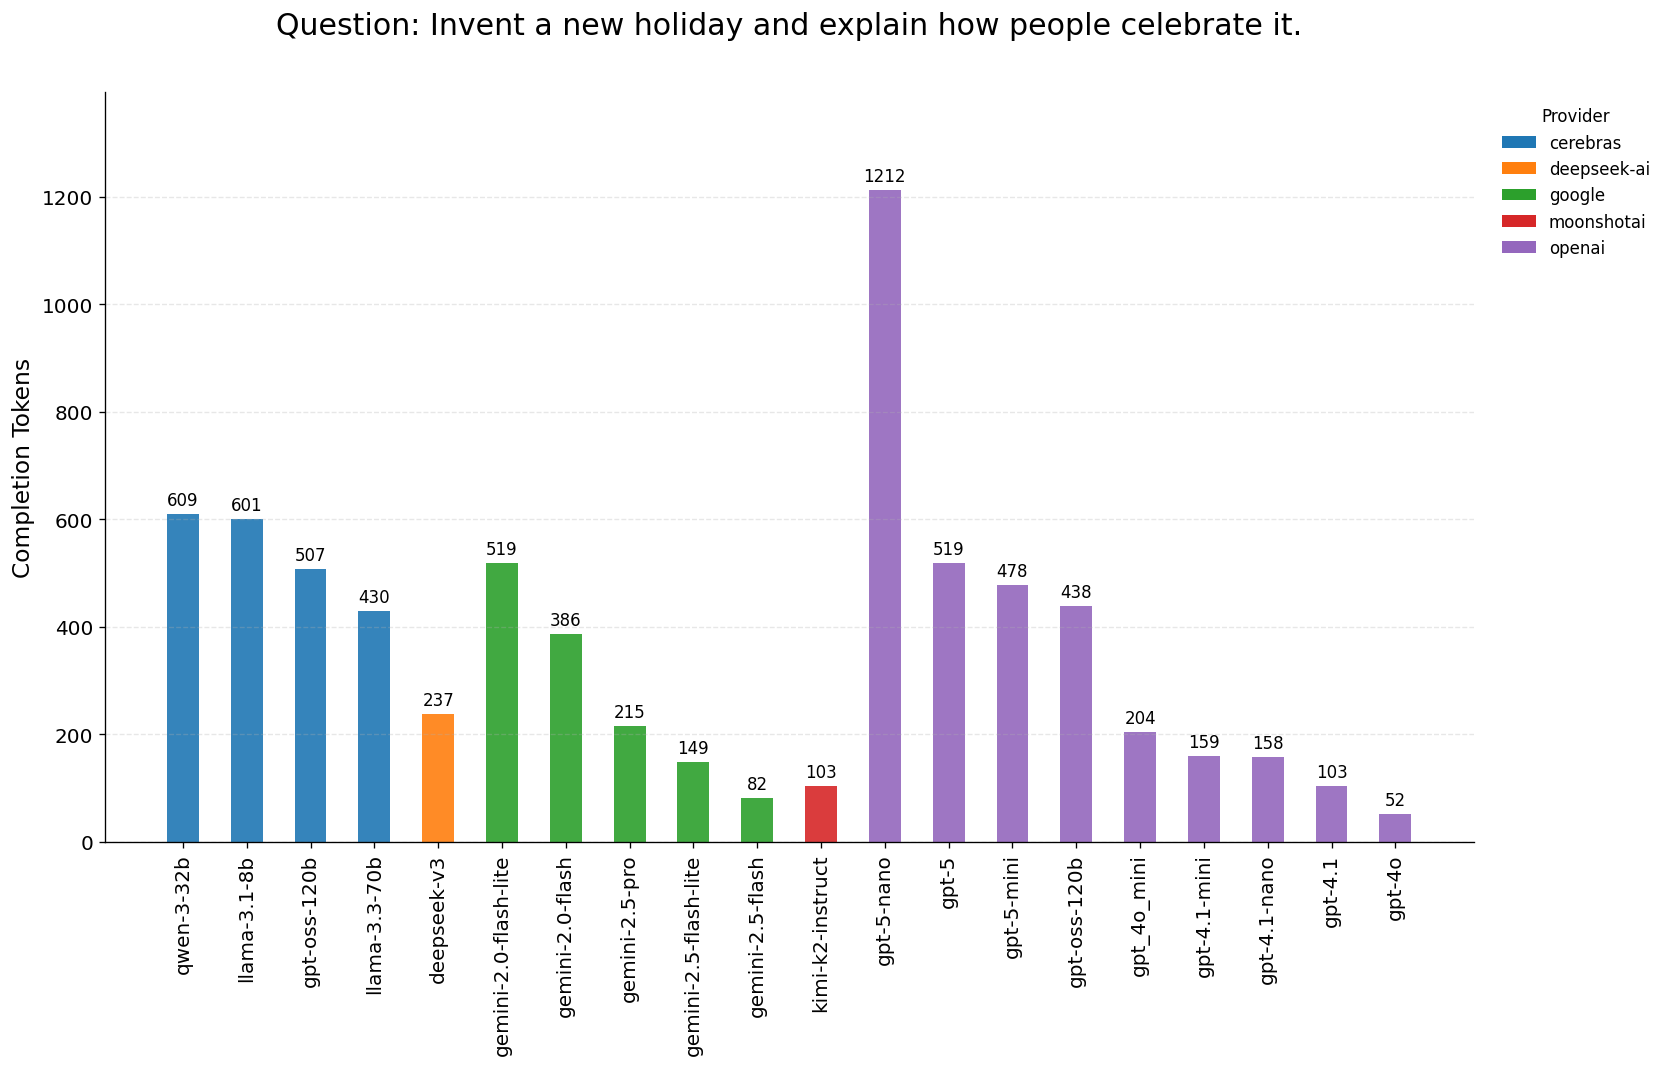

In [170]:
plot_completion_tokens(quest_dfs[11], questions[11])

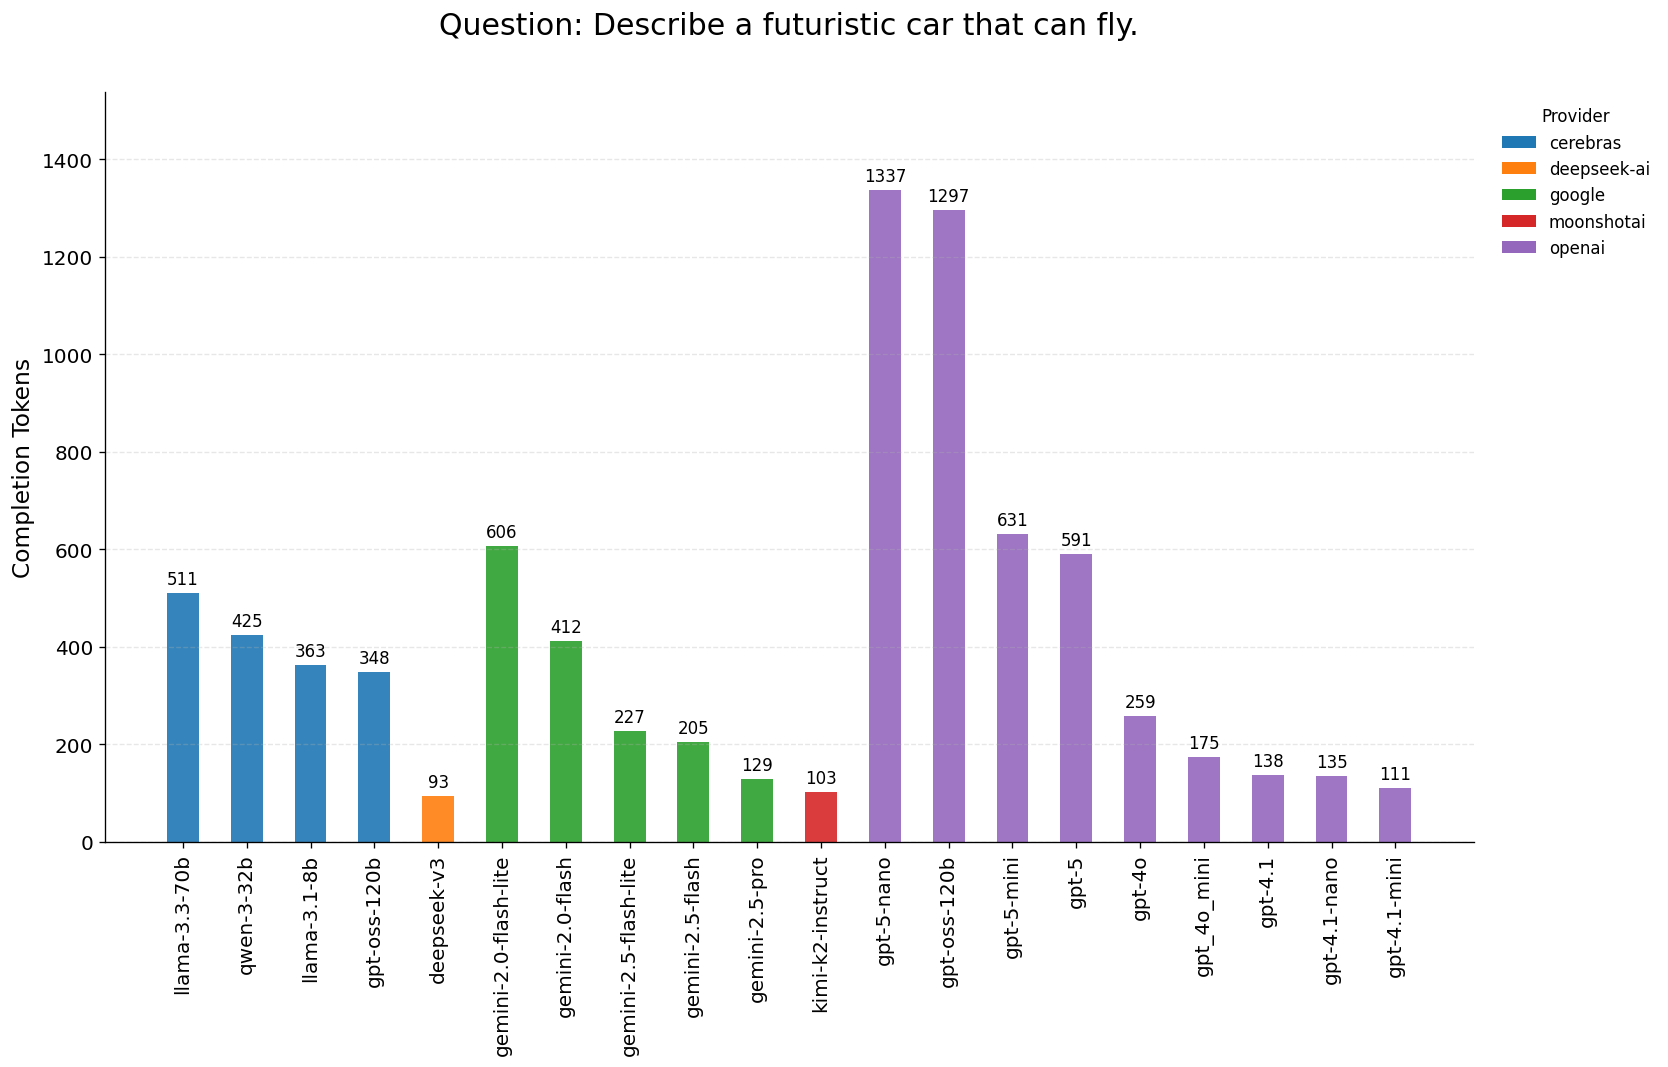

In [171]:
plot_completion_tokens(quest_dfs[12], questions[12])

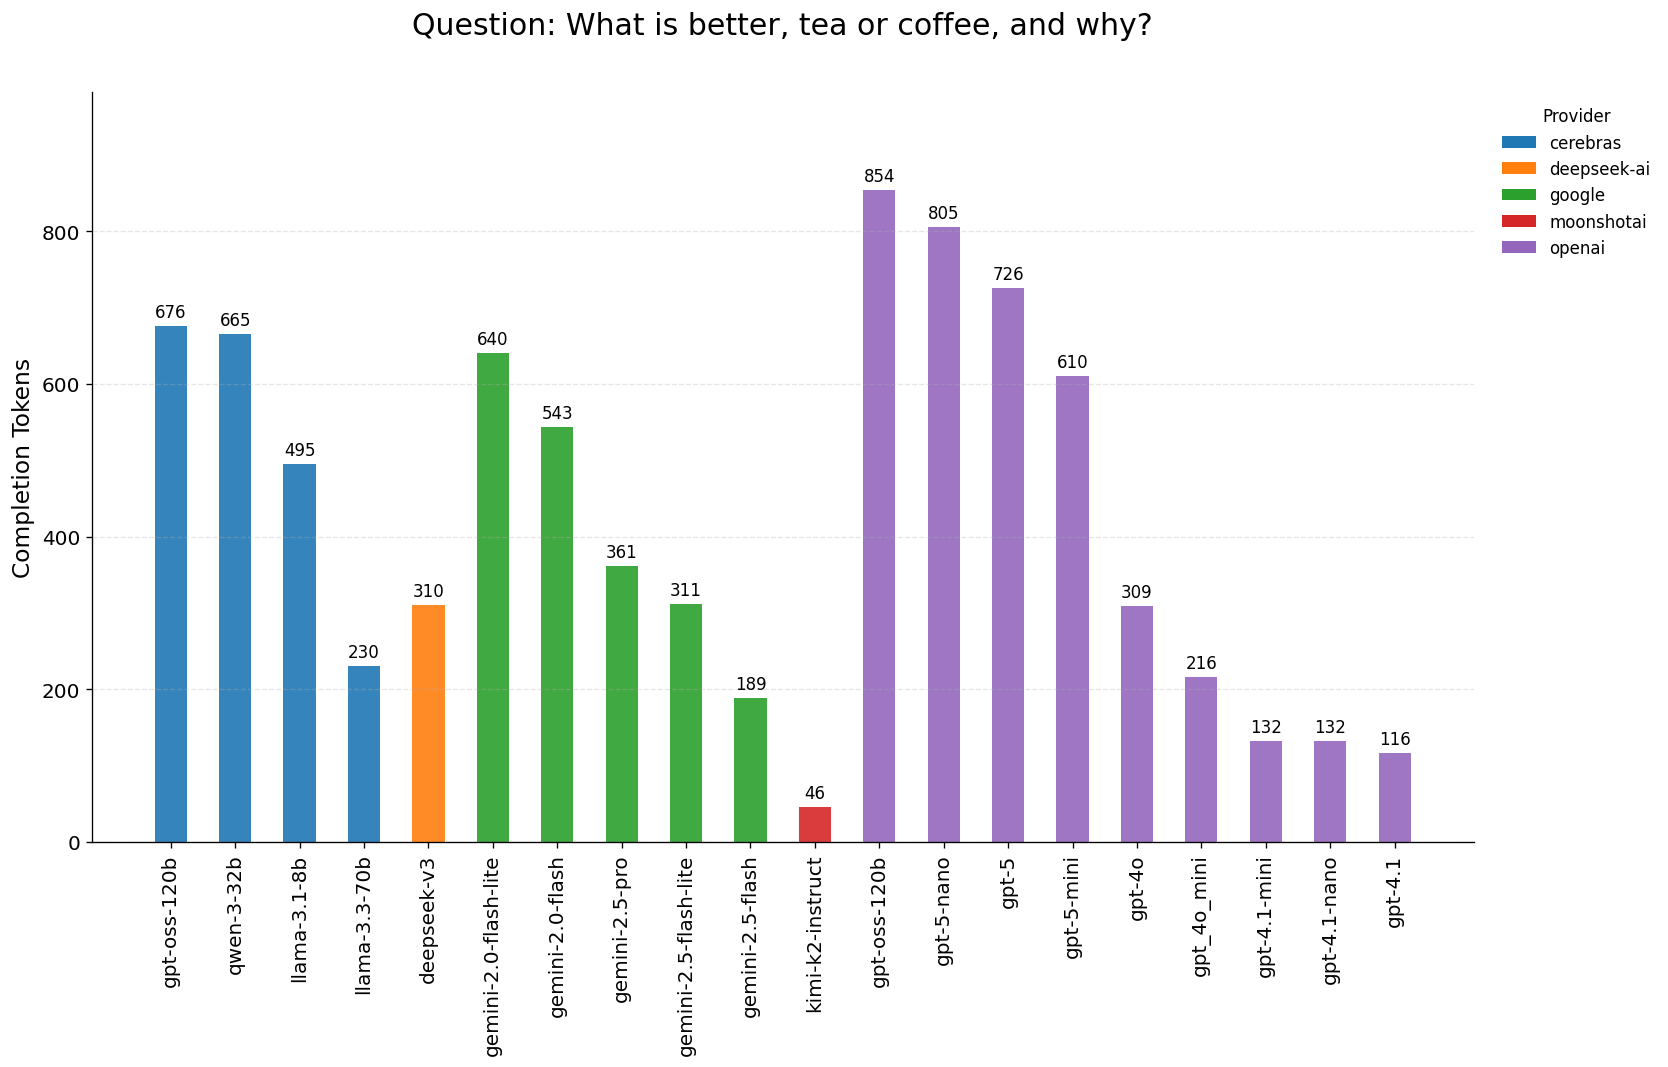

In [172]:
plot_completion_tokens(quest_dfs[13], questions[13])

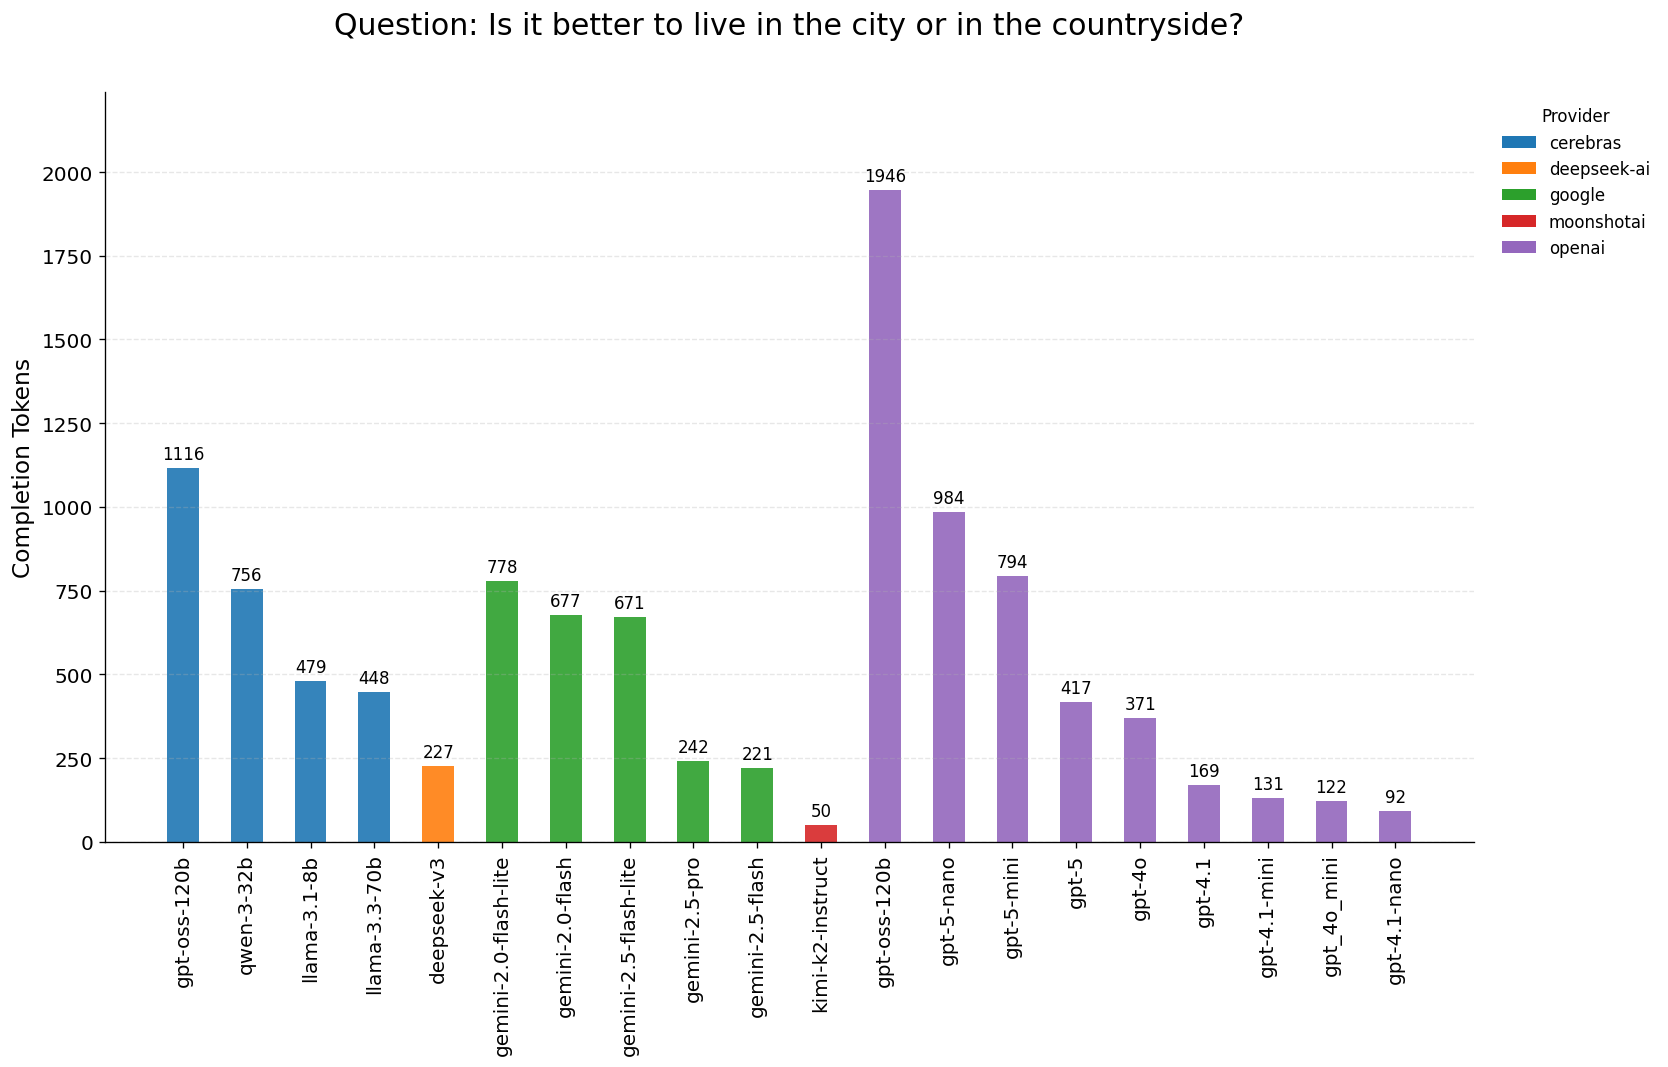

In [173]:
plot_completion_tokens(quest_dfs[14], questions[14])

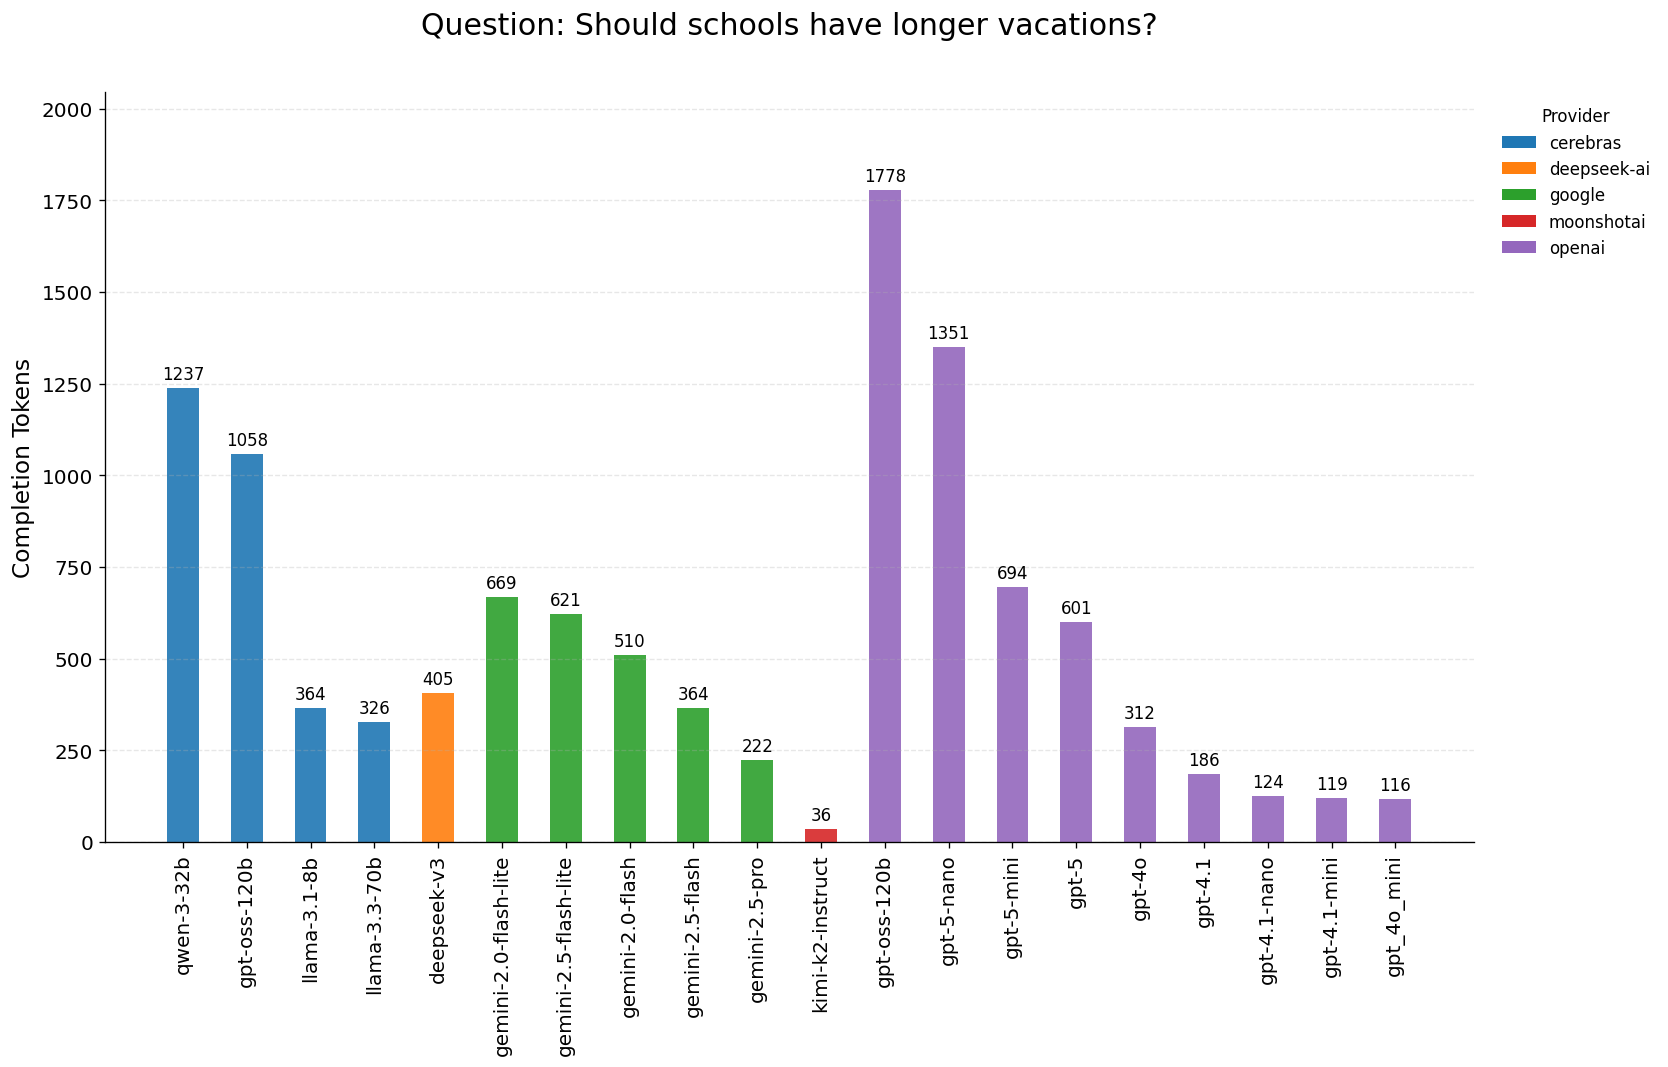

In [174]:
plot_completion_tokens(quest_dfs[15], questions[15])